# Market Volatility Forecasting using GARCH models

# Table of contents
1. [Introduction](#introduction)
2. [Analysis of FTSE MIB returns, distribution and anomalies](#paragraph1)
    1. [Sub paragraph](#subparagraph1)
3. [Another paragraph](#paragraph2)

In [166]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

from scipy import stats

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_squared_error, mean_absolute_error

## Introduction. Data Manipulation and creation of custom functions

In [167]:
# Plotting options

sns.set(style="darkgrid", color_codes=True)

#### Download data from Yahoo Finance

In [168]:
df = yf.download("FTSEMIB.MI", start='2004-01-01', end='2023-12-14')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,26887.0,27384.0,26887.0,27384.0,27384.0,212731500
2004-01-05,27384.0,27563.0,27292.0,27530.0,27530.0,414679300
2004-01-06,27530.0,27662.0,27421.0,27652.0,27652.0,332292700
2004-01-07,27652.0,27652.0,27148.0,27187.0,27187.0,746970800
2004-01-08,27187.0,27532.0,27187.0,27503.0,27503.0,938375300
...,...,...,...,...,...,...
2023-12-07,30297.0,30343.0,30053.0,30122.0,30122.0,421882000
2023-12-08,30150.0,30427.0,30058.0,30404.0,30404.0,315888900
2023-12-11,30418.0,30470.0,30303.0,30427.0,30427.0,309967400


#### Calculate log returns

Log returns are calculated as follows:

$return_t = log(\frac{P_t}{P_{t-1}})$

In [169]:
returns = pd.Series(np.log(df['Adj Close']/df['Adj Close'].shift(1)), index = df.index).dropna()
returns 

Date
2004-01-05    0.005317
2004-01-06    0.004422
2004-01-07   -0.016959
2004-01-08    0.011556
2004-01-09   -0.002257
                ...   
2023-12-07   -0.006750
2023-12-08    0.009318
2023-12-11    0.000756
2023-12-12   -0.002797
2023-12-13   -0.001517
Name: Adj Close, Length: 5080, dtype: float64

#### Define plotting function for the time series

This function will be useful to take a look at a series' characteristics by looking at the QQ plot, ACF plot and PACF plot. 

In [170]:
def ts_plot(series : pd.Series, max_lags : int, title : str):

    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot the series
    axs[0, 0].plot(series)
    axs[0, 0].set_title('Series')

    # QQPLOT
    qqplot(series, ax = axs[0, 1], line='s')
    axs[0, 1].set_title('QQ plot')

    # ACF PLOT
    plot_acf(series, lags=max_lags, ax = axs[1, 0], zero=False) # zero = False to not include lag 0
    axs[1, 0].set_title('Autocorrelation plot')
    axs[1, 0].set_xlabel('Lag')

    # PACF PLOT
    plot_pacf(series, lags=max_lags, ax = axs[1, 1], zero=False)
    axs[1, 1].set_title('Partial Autocorrelation plot')
    axs[1, 1].set_xlabel('Lag')

    fig.suptitle(title, fontsize=20)
    axs[1, 0].autoscale()
    axs[1, 1].autoscale()

Before proceeding to model the returns volatility using GARCH models, we shall discuss some characteristics of the returns and of the volatily of returns.

## Analysis of FTSE MIB returns, distribution and anomalies <a name="paragraph1"></a>

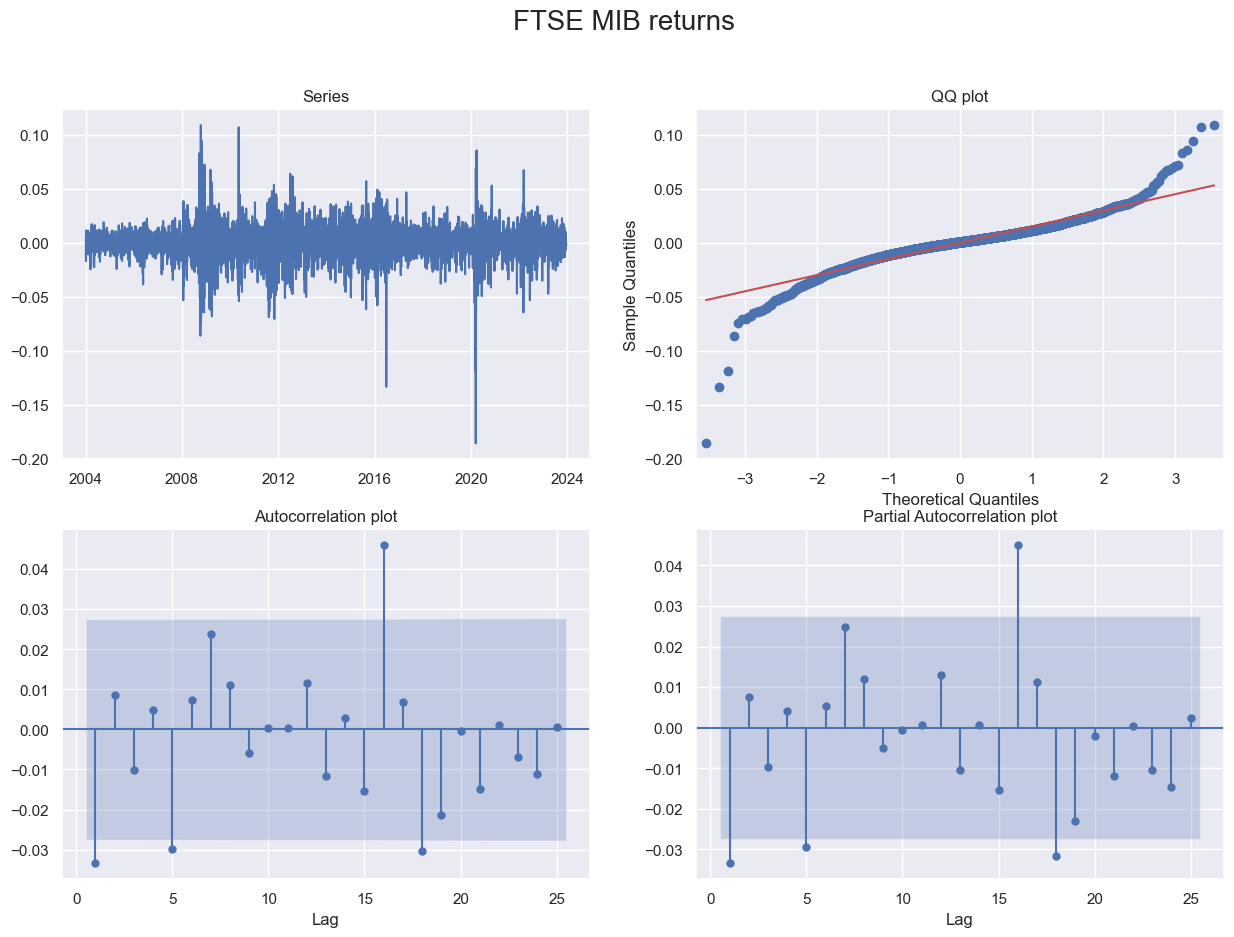

In [171]:
ts_plot(returns, 25, 'FTSE MIB returns')

As we can see, no serial correlation seems to appear in the returns. Even if there are some significant lags that exhibit correlation in both the ACF and the PACF, the continuous oscillation of the correlation are tipycal of a stationary series and indicate some form of independence in the observations. 

However, we can't stop our analysis here. To ensure that this is an independent series, or rather to test that it is not, we may recall the fact that an independent series is one in which transformations of the series are themselves independent. 

So let's now examine the squared of the returns in the following plot. Squared of returns are basically an aproximation (an unbiased estimate) of the volatility (if one assumes that the mean of the returns is zero, or returns are normally distributed). Comparing the following ACF and PACF plots with the previous one, the populated presence of significative positive correlations at different time lags suggest that the log returns are indeed serially uncorrelated but dependent. And <u>hence, some kind of non dependence in the returns exist, as shown by the squared returns</u>.

Additionally, this behaviour in the squared returns confirm the phenomenom of volatility clustering, since many lags of the squared returns (a sort of aproximation of the volatility) are highly correlated and hence, volatility causes more volatility and period of clusters.

ARCH models will attempt to capture such dependence in the return series.

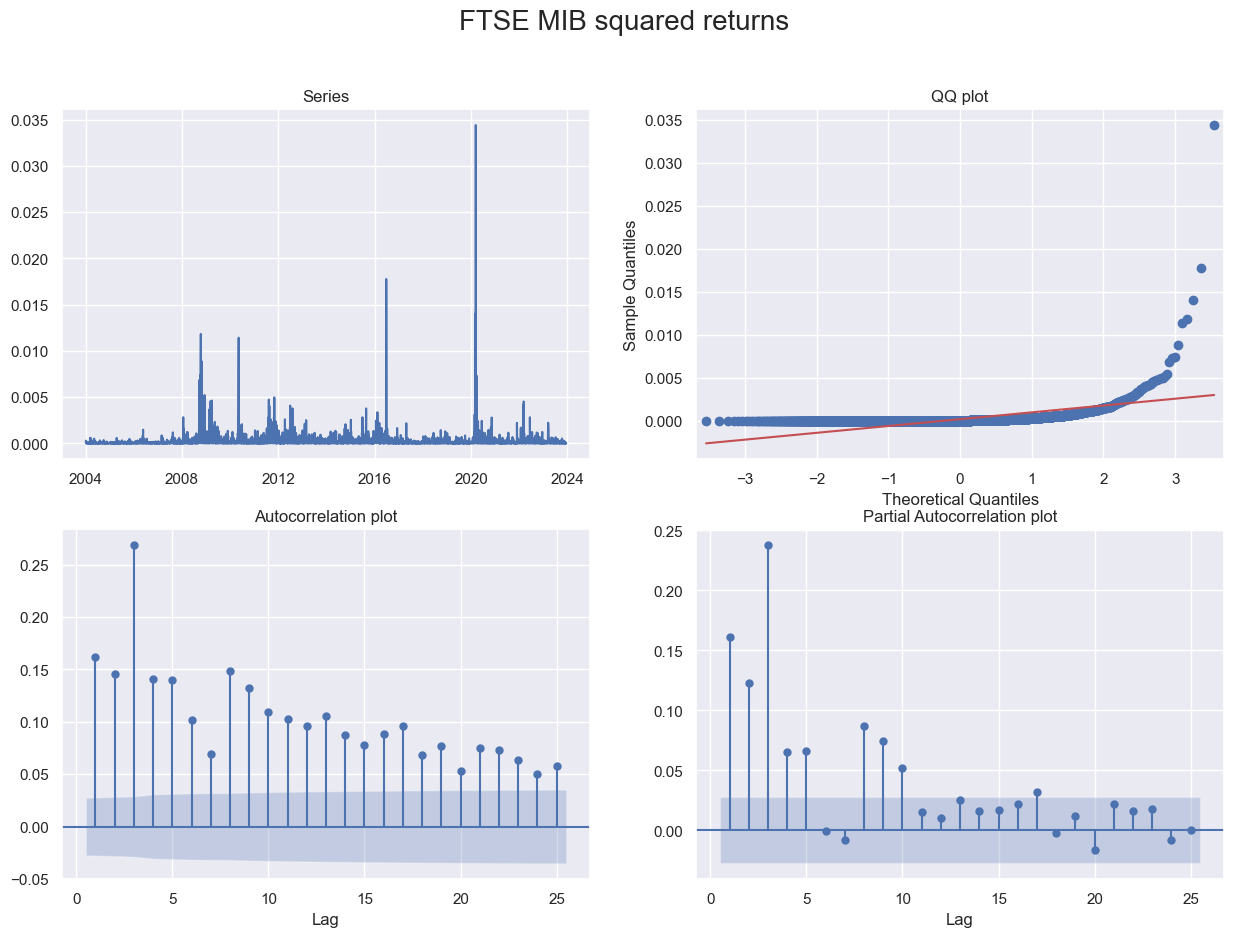

In [172]:
ts_plot(returns**2, 25, 'FTSE MIB squared returns')

#### Ljung-Box test 

Another way to check the presence of autocorrelation in the data is using the Ljung Box test statistic, for which:

- $H_0$ : The data are independently distributed; No Autocorrelation
- $H_1$ : The data are not independently distributed; they exhibit serial correlation.

In [173]:
sm.stats.acorr_ljungbox(returns**2, lags=None, auto_lag=True)

,lb_stat,lb_pvalue
1,132.610869,1.099894e-30
2,240.326851,6.511594e-53
3,606.831339,3.329944e-131
4,707.013960,1.055587e-151
5,805.990269,5.852830e-172
...,...,...
112,2148.483670,0.000000e+00
113,2149.565549,0.000000e+00
114,2151.558033,0.000000e+00
115,2158.234116,0.000000e+00


In [174]:
# check if any lag pvalue is statistically not significant
(sm.stats.acorr_ljungbox(returns**2, lags=None, auto_lag=True)['lb_pvalue'] > 0.05).sum() 

0

Since all p-values are smaller than 0.05 we reject the null hypotheses and can conclude that there is AUTOCORRELATION in the variance of the data (in the squared returns).

#### Returns Distribution

Let's now focus on the distribution of the returns and observe possible anomalies.

Text(0.5, 1.0, '2nd anomaly: higher spike of FTSE returns distribution')

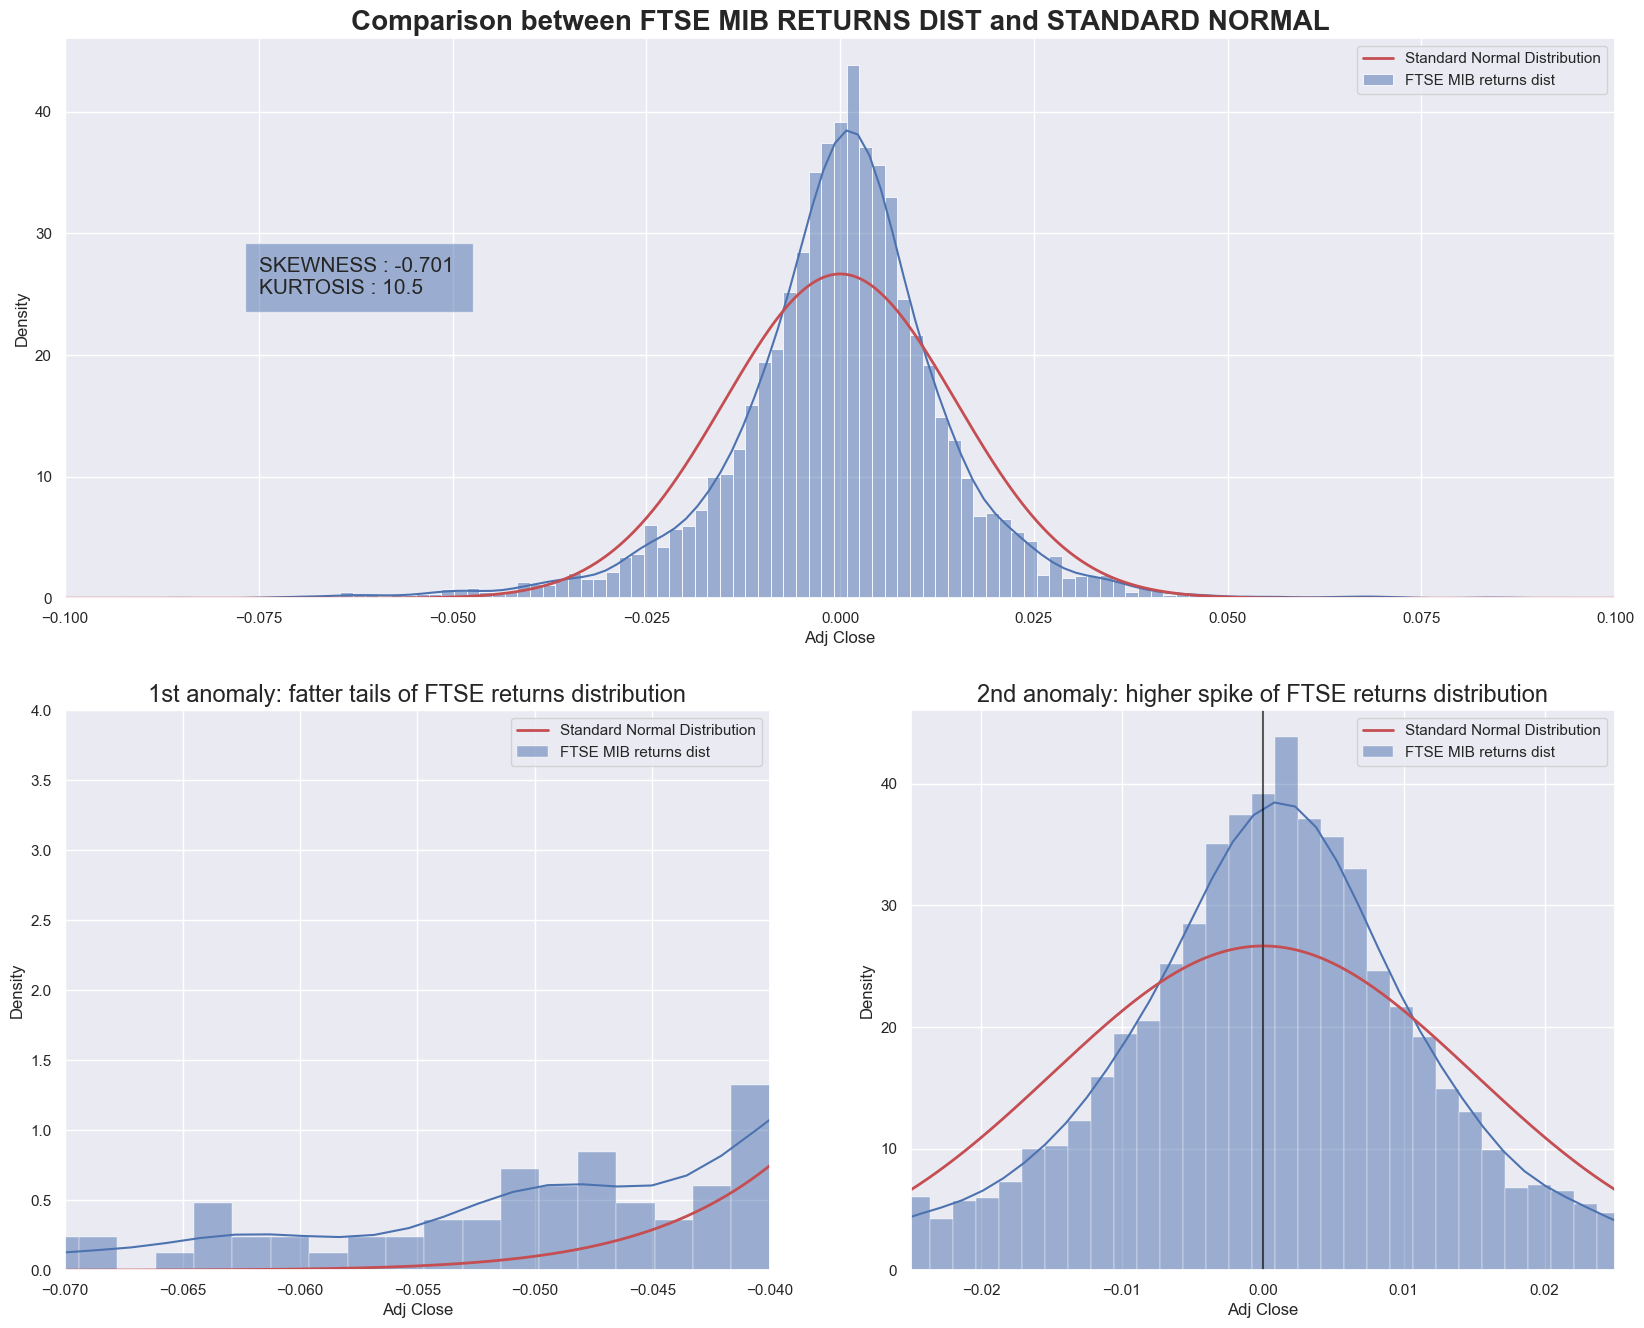

In [175]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

gs = fig.add_gridspec(2, 2)
ax = fig.add_subplot(gs[0, :])
axs[0, 0].set_yticks([])
axs[0, 0].set_xticks([])
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])


sns.histplot(returns, stat='density', kde=True, label='FTSE MIB returns dist')
ax.set_xlim([-0.10, 0.10])
x = np.linspace(-0.1, 0.1, 1000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
ax.plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
ax.legend()
ax.set_title('Comparison between FTSE MIB RETURNS DIST and STANDARD NORMAL', fontsize=20, fontweight='bold')
ax.text(-0.075, 25, f'SKEWNESS : {returns.skew():.3} \nKURTOSIS : {returns.kurtosis():.3}', style='normal',
        bbox={'alpha': 0.5, 'pad': 10}, fontsize=15)

# Lower-left plot (focus on left fat tail)
sns.histplot(returns, stat='density', kde=True, ax = axs[1, 0], label='FTSE MIB returns dist')
axs[1, 0].set_xlim([-0.07, -0.04])
axs[1, 0].set_ylim([0, 4])
x = np.linspace(-0.07, -0.04, 10000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
axs[1, 0].plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
axs[1, 0].legend()
axs[1, 0].set_title('1st anomaly: fatter tails of FTSE returns distribution', fontsize=17)


# Lower-right plot (focus on the central leptokurticity)
sns.histplot(returns, stat='density', kde=True, ax = axs[1, 1], label='FTSE MIB returns dist')
axs[1, 1].set_xlim([-0.025, +0.025])
axs[1, 1].axvline(0, c='black', alpha=0.4)
x = np.linspace(-0.025, +0.025, 10000)
p = stats.norm.pdf(x, np.mean(returns), np.std(returns))
axs[1, 1].plot(x, p, 'r', linewidth=2, label='Standard Normal Distribution')
axs[1, 1].axvline(0, c='black', alpha=0.4)
axs[1, 1].legend()
axs[1, 1].set_title('2nd anomaly: higher spike of FTSE returns distribution', fontsize=17)



In [176]:
print('Skewness:', returns.skew(), '\nKurtosis:', returns.kurtosis())

Skewness: -0.7012824029168813 
Kurtosis: 10.542954261622777


As we can observe from the previous plot and from the printe characteristichs of the distribution, there two main observations we can derive:

1) **Kurtosis**. The distribution of returns of the FTSE MIB present a clear leptokurticity, the high positive value for the kurtosis and the spikes in the central part of the distribution that we can visualize from the previous plot, confirms a typical behaviour in financial returns of the equity market. In addition, leptokurticity reflects another charactertics in the distribution. The so called *fatter tails* (as shown in the lower left plot of the previous figure) implies that returns have a higher probability of extreme events (both positive and negative) compared to a normal distribution. This means that large price movements, both in the positive and negative tail, are more probable that what would be expected under the normal distribution assumption.  

2) **Skewness**. The distribution of the returns presents a negative skewness. When compared to a normal distribution, this skewness suggests that the distribution of returns has a longer left tail. This is reflected in the fact that there is a higher probability of large negative returns comapred to large positive returns. This characeristic is important in the context of risk management, and analysing it can help the banks and financial institutions in choosing the right strategies to counter extreme negative events. 


This two characertistics are really important, and enter in the discussion of the *stylized facts of financial returns*. The other two remaining *facts* are the following:

> 3) *The presence of a difference in the behavior of short term returns (such as daily) and long term returns (such as monthly or quarterly)*
>
> 4) *The tendency of extreme returns to happen in clusters, very closely in time (volatility clustering)*

Naturally, this common characteristics have to be correctly modeled in order to capture the anomalies in the financial returns:

> *To model the characteristics of observed return distributions, approaches generally fall into one of three categories:*
> 1. *Assume that returns have stable distributions of infinite variance.*
> 2. *Assume that returns have distributions that are more fat-tailed and/or skewed than the normal distribution.*
> 3. *Assume that the distributions of returns are normal at each instant of time, but look fat tailed due to fluctuations in the variance(volatility) of these distributions. Incorporate the fluctuations in the volatility using ARCH/GARCH or other models.* 


        Ref: Portfolio Construction and Analytics, Frank J. Fabozzi, Wiley (2016), p.78

In the following notebook we are going to focus on the third assumption, by trying to model the fluctuations (and clusters) of the returns volatility, implementing various GARCH and GARCH derived models. 


## Volatility Clustering and Market Regimes

After dealing with the main returns anomalies, there is still a second issue that we've just introduced: volatility clustering. 

A visual inspection of the returns series should give us a first glance at this phenomenom. In the following figure, the returns series is plotted with a 21 days rolling volatility. 

(-0.1, 0.1)

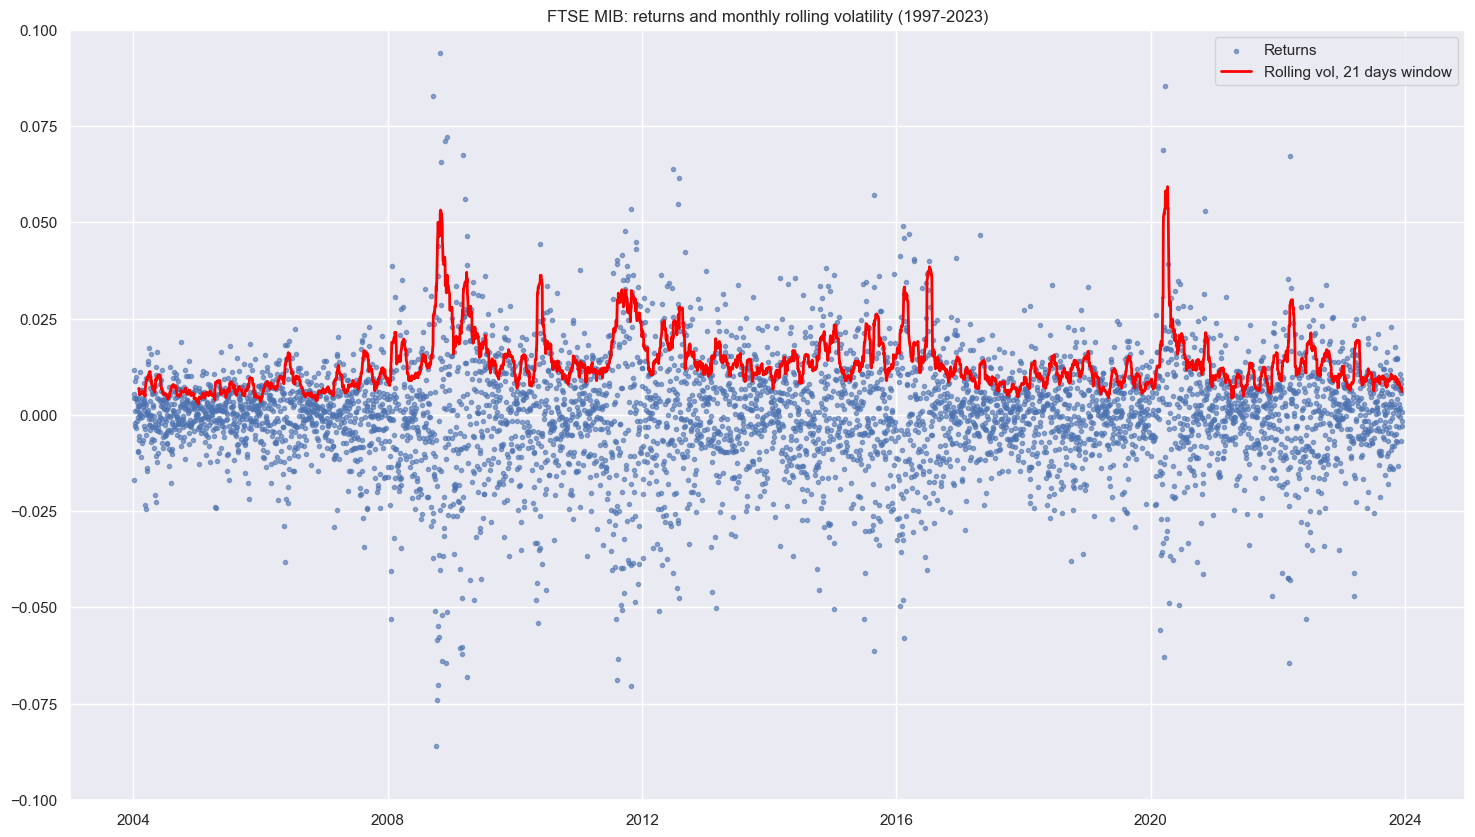

In [177]:
plt.figure(figsize=(18, 10))
plt.scatter(returns.index, returns, marker='.', label='Returns', alpha=0.6)

onem_vol = pd.Series(returns.rolling(window=21).std(), index = returns.index)
plt.plot(onem_vol, color='red', label='Rolling vol, 21 days window', linewidth=2)

plt.title('FTSE MIB: returns and monthly rolling volatility (1997-2023)')
plt.legend()
plt.ylim([-0.1, +0.1])

#### Volatility clustering

As we can see from the previous plot, it's clear how there are alternating periods in the behaviour of the returns (and its volatility). There is the persistence of periods in which the oscillations of the returns are more pronounced and cause a persistent increase in the volatility of the market. On the contrary, there are periods in which the market returns are more stable and tend to be associated with prolonged phases of constant volatility. 

These two arguments form the basis of the **volatility clustering** phenomenom. 

> Volatility clustering refers to the observation that large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes. This phenomenom led during the 80s the development of new models that could be sensible and robust to this behaviour in the volatility: the ARCH and GARCH family of models. 

#### Market regimes

As we have understood, this periods of concentrated high volatility are tipycal of more general trends in the market: market regimes. But how we can observe these regimes? The following part of the notebook will try to showcase the presence of different regimes in the series of FTSE MIB by leveraging an unsupervised learning technique, KMEANS. 

### KMeans visualization of the Volatility clusters

In [178]:
from sklearn.cluster import KMeans

# let's recreate the series of rolling volatilities for 90 days (~3 months) days and annualize it 
x = np.sqrt(251) * pd.Series(returns.rolling(window=90).std().dropna())
x = x.to_frame()
x.rename(columns = {'Adj Close' : '90 days Rolling Vol'}, inplace=True) #change column name
x

,90 days Rolling Vol
Date,
2004-05-07,0.121705
2004-05-10,0.127139
2004-05-11,0.128626
2004-05-12,0.126744
2004-05-13,0.126465
...,...
2023-12-07,0.139079
2023-12-08,0.138854
2023-12-11,0.138625


In [179]:
# This function will cluster the 90 days rolling volatilies into 3 groups (k defined = 3)

def kmeans_cluster(x, n_clusters : int):
    kmeans = KMeans(n_clusters = n_clusters, n_init='auto')
    kmeans.fit(x) #fit the Kmeans algo to the data

    clusters = kmeans.predict(x) #calculate the three clusters
    
    # 1) CREATE CLUSTER SERIES
    # The following series will store the cluster center of each element in the original series
    cluster_series = pd.Series(
        # creating a Series using list comprehension
        [
            round(kmeans.cluster_centers_[cluster_id, 0], 2)  #round the clusters centers to the 2nd decimals (just for clarity)
            for cluster_id in clusters
        ],
        index = x.index
    )

    # 2) CREATE CLUSTER DATAFRAME
    clustering_df = {}  #initialize an empty dictionary
    for cluster_id in range(n_clusters):
        # Extract the aproximated vol level of the cluster center (for each cluster)
        volatility_level = round(kmeans.cluster_centers_[cluster_id, 0], 2)  

        # For each cluster, store a boolean indicator for the observations that fall within the cluster 
        # -> the df is going to be a 3 column dataframe with each column referred to a cluster 
        # -> an observation in a specific row (time ordered series) will have TRUE(=1) for a specific column only if part of the relative cluster
        clustering_df[f'Cluster {volatility_level:.3}'] = (clusters == cluster_id).astype(float)
                                                                                # astype used to convert boolean in numeric
    
    clustering_df = pd.DataFrame(clustering_df, index=x.index) # convert list in a df
    clustering_df = clustering_df[sorted(clustering_df.columns)] # sort the columns of the df
    
    return clustering_df, cluster_series

1) `CREATE CLUSTER SERIES` 
    This piece of code is creating a series (with the same dimension as the x one), in which each element have the cluster center reference. For each day, the value will indicate the cluster membership (it will indicate the center of the cluster for which the obsevation is part of).

2) `CREATE CLUSTER DATAFRAME`
    This following part of the function is more difficult. Its main purpose it's extracting a dataframe in the format of a one hot encoding. The dataframe will have as many columns as the **k** defined at the beginning, and every element in the series will have a value = 1 if it belongs to a specific cluster, a specific column. 

In [180]:
KM_cluster_df, KM_cluster_series = kmeans_cluster(x, 3)
KM_cluster_df

,Cluster 0.13,Cluster 0.22,Cluster 0.4
Date,,,
2004-05-07,1.0,0.0,0.0
2004-05-10,1.0,0.0,0.0
2004-05-11,1.0,0.0,0.0
2004-05-12,1.0,0.0,0.0
2004-05-13,1.0,0.0,0.0
...,...,...,...
2023-12-07,1.0,0.0,0.0
2023-12-08,1.0,0.0,0.0
2023-12-11,1.0,0.0,0.0


In [181]:
KM_cluster_series[:5] #the value related to each date is the cluster center for which the day is part of

Date
2004-05-07    0.13
2004-05-10    0.13
2004-05-11    0.13
2004-05-12    0.13
2004-05-13    0.13
dtype: float64

#### Volatility clusters and 3 months rolling volatility

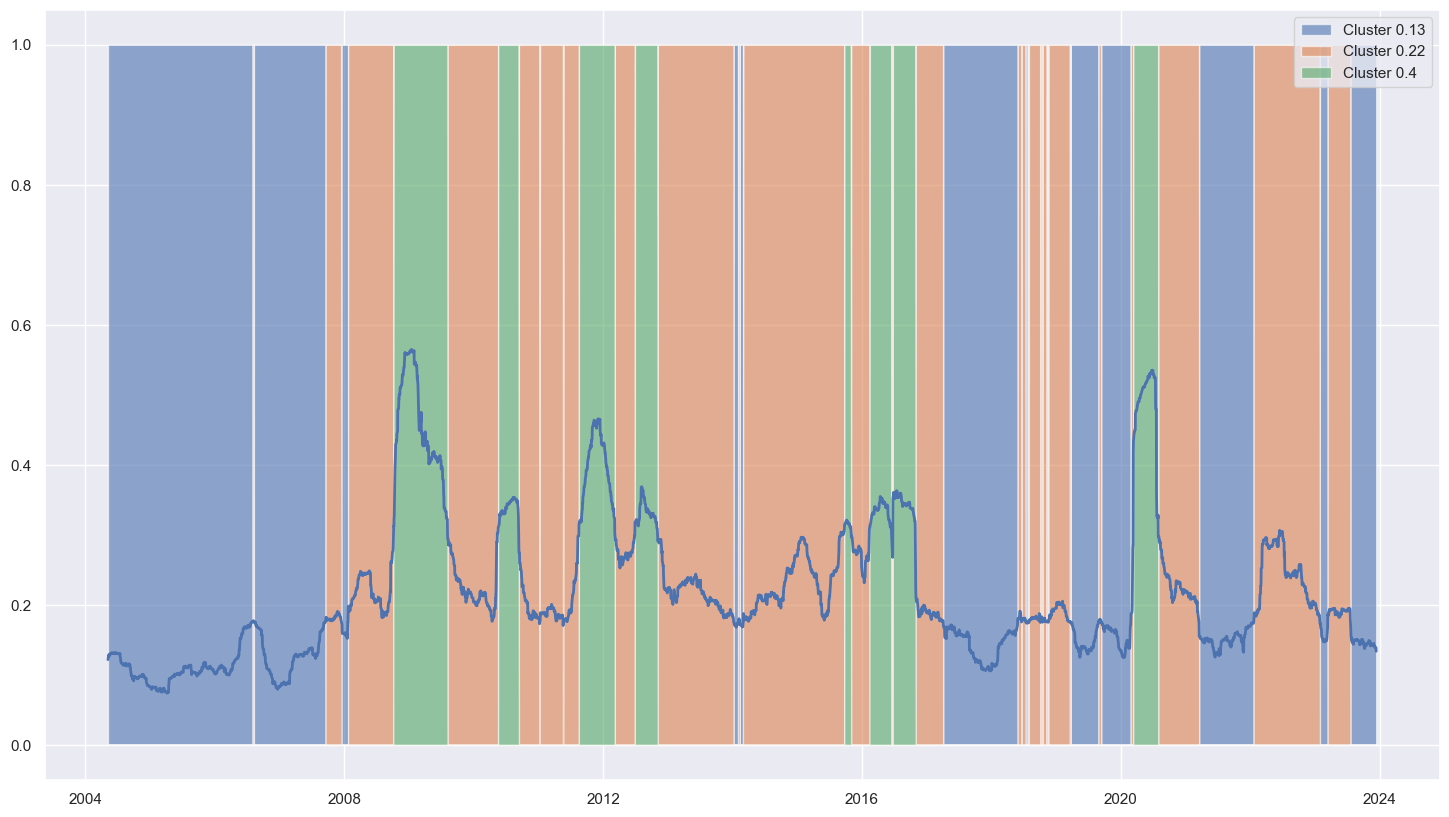

In [182]:
plt.figure(figsize=(18, 10))

for col in KM_cluster_df.columns:
    plt.fill_between(KM_cluster_df[col].index, 0, KM_cluster_df[col], alpha=0.6, label=col)

plt.plot(x, linewidth = 2)
plt.legend()

#### Volatility clusters and FTSE MIB PERFORMANCE

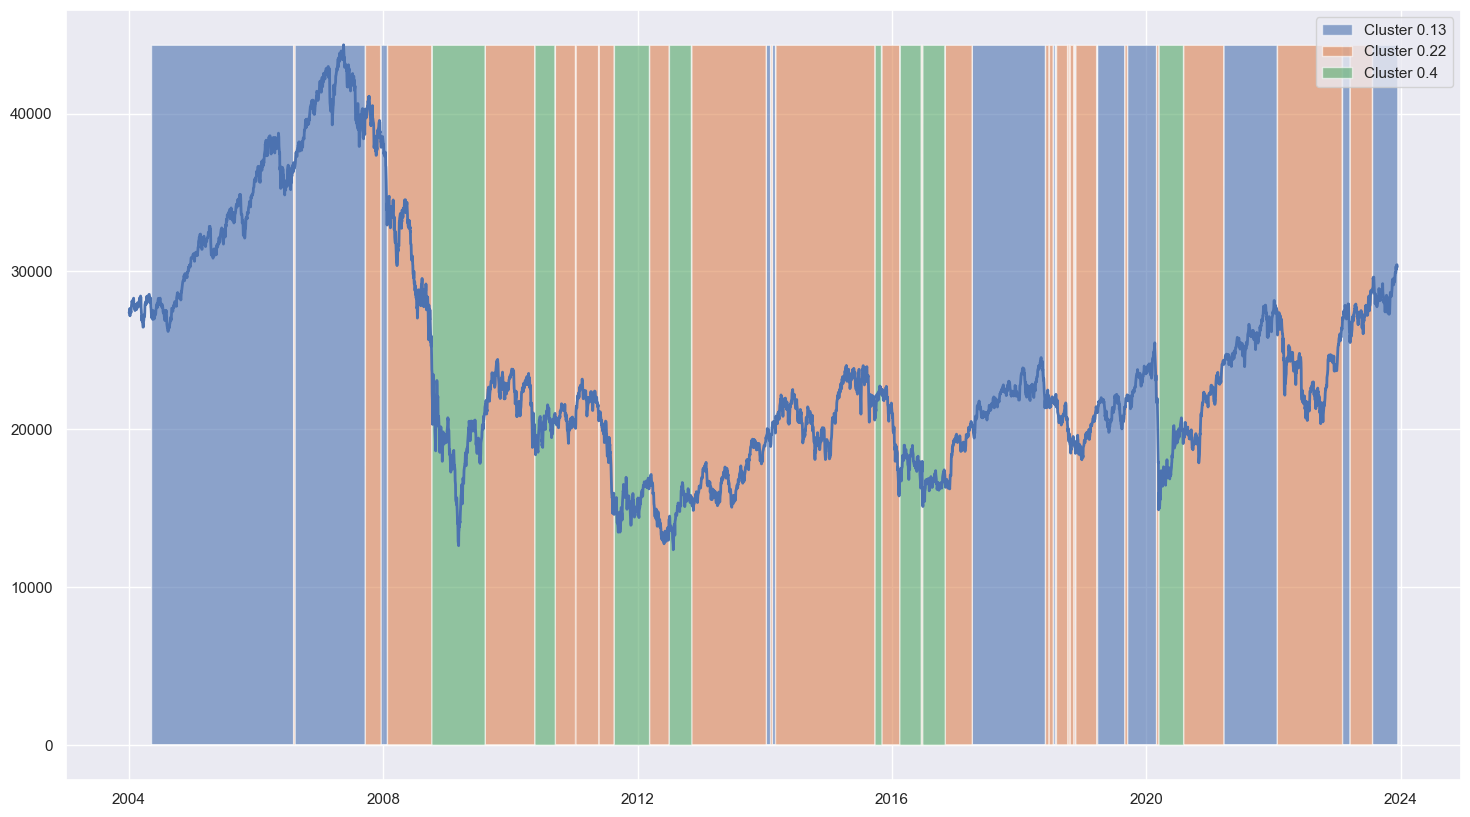

In [183]:
# Create a temporary dataframe for plotting purposes
temp = KM_cluster_df
for col in temp.columns:
    temp[col] = temp[col].apply(lambda x: x + max(df['Adj Close']) if x == 1 else x)


plt.figure(figsize=(18, 10))

for col in temp.columns:
    plt.fill_between(temp[col].index, 0, temp[col], alpha=0.6, label=col)

plt.plot(df['Adj Close'], linewidth = 2)
plt.legend()

# NOTE: graphically, the clusters are not calculated for the first 90 observations since 
# you can't calculate (and consequently cluster) the rolling volatility for the first 90 days

#### Volatility clusters and FTSE MIB PERFORMANCE (2008-2012)

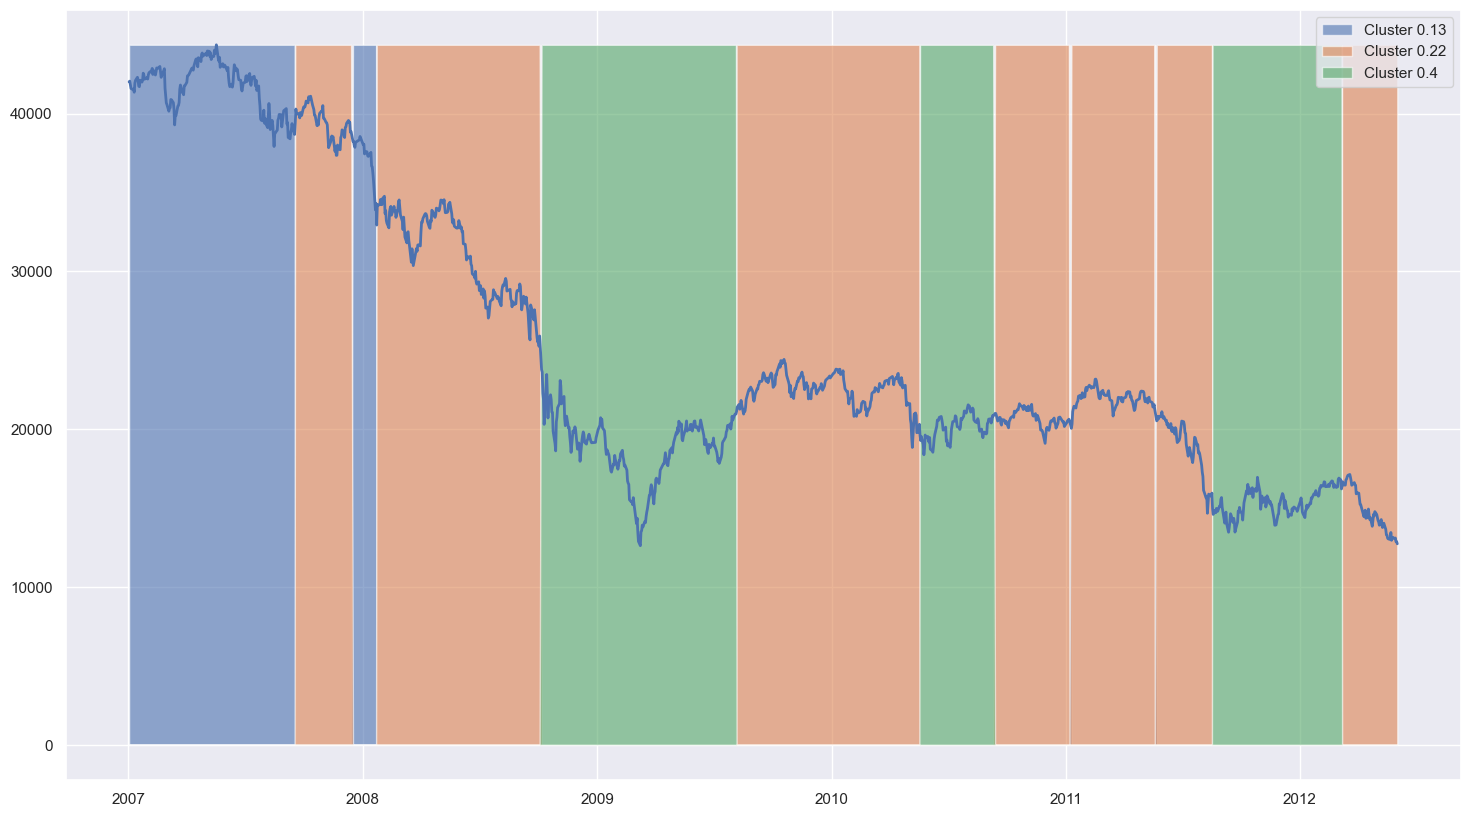

In [184]:
plt.figure(figsize=(18, 10))

for col in temp.columns:
    plt.fill_between(temp[col]['2007-01-01' : '2012-06-01'].index, 0, temp[col]['2007-01-01' : '2012-06-01'], alpha=0.6, label=col)

plt.plot(df['Adj Close']['2007-01-01' : '2012-06-01'], linewidth = 2)
plt.legend()

As we can see from the plot above, the cluster with higher vol (0.49) is the one that particularly characterized the 2008-2009 crisis (from the end of 2008 to mid of 2009) and part of the following debt crisis during 2011-2012. This periods are the  periods in which the markets is more stressed, there is a higher volatility, and returns are more probable in the extreme of the distribution (conditioned upon the specific market regimes we are considering). 
- The green areas belongs to the more volatile and riskier market regime, with higher vol and extreme positive or negative returns. 
- The orange are are part of a less riskier market regime. 
- The blue areas belongs to a market regime in which the volatility is the lower between the three. 

#### Volatility distributions conditioned on Market Regimes

In [185]:
kde_plot_df = pd.concat([x, KM_cluster_series.to_frame(name='Regimes')], axis=1)
kde_plot_df.head()

,90 days Rolling Vol,Regimes
Date,,
2004-05-07,0.121705,0.13
2004-05-10,0.127139,0.13
2004-05-11,0.128626,0.13
2004-05-12,0.126744,0.13
2004-05-13,0.126465,0.13


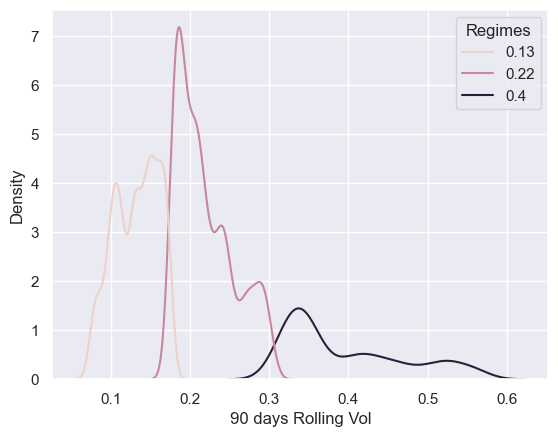

In [186]:
sns.kdeplot(kde_plot_df, x=kde_plot_df.columns[0], hue='Regimes')
plt.show()

This plot show the distribution of the volatily in the three different regimes we identified with the KMEANS. 

#### Returns distributions conditioned on Market Regimes

We can also look at the distribution of the returns under the three different regimes. 

In [187]:
#First, concatenate the cluster series (containing the cluster centers) and the return series
kde_plot_ret_df = pd.concat([returns, KM_cluster_series.to_frame(name='Regimes')], axis=1) 
kde_plot_ret_df.rename(columns = {'Adj Close' : 'Returns'}, inplace=True) 
kde_plot_ret_df.dropna(inplace=True)
kde_plot_ret_df.head()


,Returns,Regimes
Date,,
2004-05-07,-0.001696,0.13
2004-05-10,-0.022574,0.13
2004-05-11,0.012336,0.13
2004-05-12,-0.010786,0.13
2004-05-13,0.010421,0.13


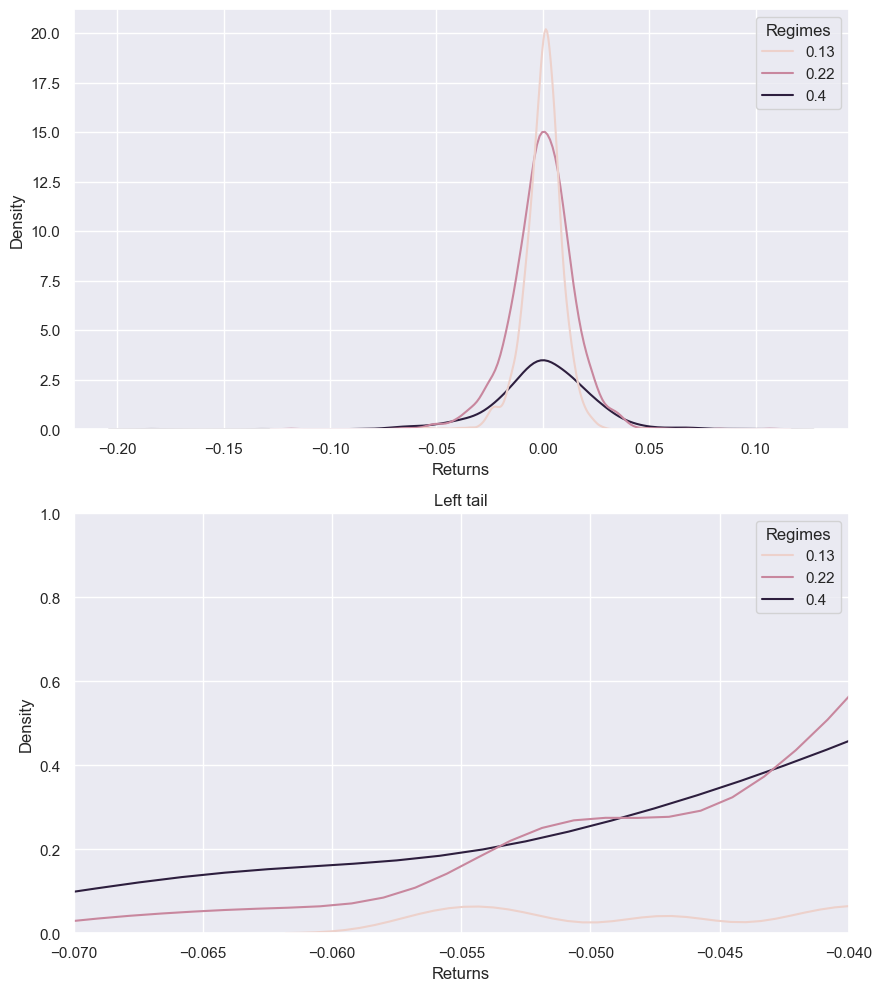

In [188]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))


sns.kdeplot(kde_plot_ret_df, x=kde_plot_ret_df.columns[0], hue='Regimes', ax=axs[0])

# Focus on the left tail
sns.kdeplot(kde_plot_ret_df, x=kde_plot_ret_df.columns[0], hue='Regimes', ax=axs[1])
axs[1].set_xlim([-0.07, -0.04])
axs[1].set_ylim([0, 1])
axs[1].set_title('Left tail')

plt.show()

As we can see in the black market regime (the one with higher volatility) the spike of the distribution is significantly lower, central returns (small movements in the market) are less probable to happen with respect to other market regimes. Instead, tails are clearly heavier and so extreme returns are more likely to happen. 

It's clear from this part of the analysis that a model capable of dealing with the returns anomalies and with the volatility eteroschedasticity is necessary. For this reasons, ARCH and GARCH model were developed and are going to be discussed shortly. 

## Data Preprocessing



#### Scale Returns

In order for the returns to be fed to the model, we should scale them by multiplying them by 100 (creating integer % values for the returns). 
This is a requirement of the `ARCH` library we are going to use to model GARCH models.


In [189]:
returns *= 100
returns[:10]

Date
2004-01-05    0.531742
2004-01-06    0.442174
2004-01-07   -1.695914
2004-01-08    1.155617
2004-01-09   -0.225684
2004-01-12    0.109266
2004-01-13   -0.284340
2004-01-14    0.865082
2004-01-15    0.400918
2004-01-16    0.428035
Name: Adj Close, dtype: float64

#### Realized Volatility

Before diving into the intricancies of the various MODELS, there is a clarification to be made. In order to measure the performances of the models, we need an historical ‘actual volatility’ series, that can be compared to the various forecasts thourgh error measures. The problem is that true underlying volatility (formally characterized by variance or the standard deviation), being a feature of the data generating process, is always UNOBSERVABLE, and this makes difficult to evaluate the forecasting performance of conditional heteroscedastic models. The best thing we can do is to extract the realized volatility using an estimating method in order to compare it to the conditional, and the forecasted volatilities that the GARCH results will provide. 

There are many ways in which researchers generate this observed, or realized actual volatility:
-  This can be deducted from the Options Market by calculating the implied volatility from financial derivatives on the security we are considering (however, this implied volatility is derived under the assumption that the price of the underlying asset follows a geometric Brownian motion). 

- Alternatively, there are methods that leverage on high-frequency data. If intraday data is available (such as 10 minutes returns), you can estimate daily volatility, calculating  the average of the square sum of the multiple intraday returns. 

- Another practice, proposed by Pagan & Schwert, represent past volatility by the squared residuals from a conditional mean model, such as 

    $$ r_t = m_t + \epsilon_t $$

    where $m_t$ is the conditional mean process (with AR and/or MA terms) while the error term can be decomposed as $\epsilon_t = \sigma_{t} z_t$, where $z_t$ is a zero-mean, constant-variance noise term.

- There are also formula-based estimators, such as the Garman-Klass formula (*On the Estimation of Securities Price Volatilities from Historical Data*, The Journal of Business, Jan 1980). 

    Garman and Klass derived the following formula, an estimator defined as *best analytic scale-invariant estimator* :
    $$ {\large\sigma_t} = 0.511(u_t - d_t)^2 - 0.019\big[c_t(u_t + d_t) - 2u_td_t \big]-0.383c^2_t$$  

    where:

    - $u = \log{\text{High}} - \log{\text{Open}}$
    - $d = \log{\text{Low}} - \log{\text{Open}}$
    - $c = \log{\text{Close}} - \log{\text{Open}}$

    and: 
    - $Open$ is the opening price on the considered day
    - $Close$ is the closing price on the considered day
    - $Low$ is the lowest price reached on the considered day
    - $High$ is the highest price peaked on the considered day 

<br />


For simplicity, in this notebook the Realized Volatility will be calculated as:

$$ \large \sigma_t = \frac{1}{\tau} \sum_t^{\tau}{(r_t - \bar{r_t})^2} $$


and by fixing $\tau = 22$, and assuming $\bar{r_t} \approx 0 $ (normality assumption in returns), the formula it's an equally weighted mean of the squared log returns on the subsequent 22 days (~ 1 month) after time $t$.

In [190]:
# REALIZED VOLATILITY
# def realized_VOL(series):
#    vol = pd.Series(series.rolling(window=22).std().shift(-21))

#    return vol

# realized_vol = realized_VOL(returns) # LAST 21 OBSERVATIONS ARE GOING TO BE MISSING
# realized_vol.dropna(inplace=True)

In [191]:
def GarmanKlass(data : pd.DataFrame):
    
    # Extract the series length
    n = len(data)
    
    # Extract the adjusting coefficient
    coeff = data['Adj Close'] / data['Close'] #adjusting coefficient
    
    # Adjust the high low open close 
    H = np.log(data['High'] * coeff)
    L = np.log(data['Low'] * coeff)
    O = np.log(data['Open'] * coeff)
    C = np.log(data['Close'] * coeff)
    
    # Calculate normalized returns
    u = (H - O) * 100 #between high and open
    d = (L - O) * 100 #between low and open
    c = (C - O) * 100 #between close and open
    
    ## Calculate the GK VARIANCE estimator
    x = 0.511 * (u - d)**2 + (-0.019) * (c * (u + d) - 2 * u * d) + (-0.383) * c**2
    
    # return the series
    return pd.Series(np.sqrt(x), index = data.index, name='Volatility') 

realized_vol = GarmanKlass(df[['Open', 'High', 'Low', 'Close', 'Adj Close']])
realized_vol.head()

Date
2004-01-02    0.604706
2004-01-05    0.615687
2004-01-06    0.555426
2004-01-07    0.753799
2004-01-08    0.522870
Name: Volatility, dtype: float64

<Axes: xlabel='Date'>

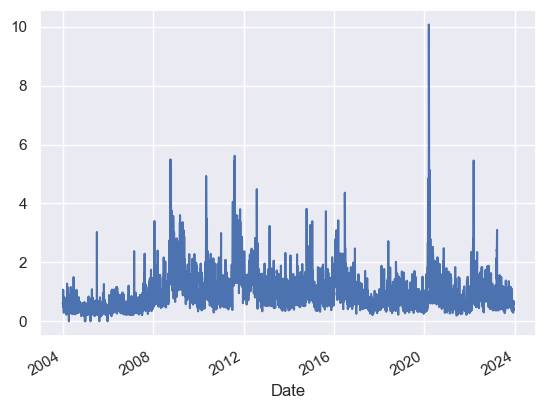

In [192]:
realized_vol.plot()

## ARCH & GARCH Models Intuition

#### Returns

As we understood before, financial returns appeared to be serially uncorrelated but dependent in some way. 
This is the basic idea of volatility models that try to capture this sort of dependence in the returns and describe the returns as:

$$r_t = \mu_t + \epsilon_t$$

where $\mu_t$ is a mean process that can be defined with AR and MA models (or as a costant process), and $\epsilon_t$ is referred as the shock of innovation of the asset return at time t (the residual).

#### ARCH

The `ARCH` model was the first heteroschedasticity-robust model. It was developed by Engle in 1982. 

The basic idea of ARCH models is that the shock $\epsilon_t$ at of an asset return is serially uncorrelated, but dependent, and that this dependence can be described by a quadratic function of its ($m$) lagged values, with the following equations:

$$\epsilon_t = \sigma_t  z_t \ \ \ \ (1) $$ 
$$ \sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + + \alpha_2 \epsilon_{t-2}^2 + ... + \alpha_m \epsilon_{t-m}^2 \ \ \ \ (2)$$


where:
- $z_t$ is a sequence of independent and identically distributed random variables with mean 0 and variance 1, 
- $\omega > 0$ 
- $\alpha_i \ge 0$ 

Notably, the effect of the lagged errors on the variance can be described - as Tsay explains in *Analysis of Financial Time Series* - as:

>From the structure of the model, it is seen that large past squared shocks $\epsilon_{t-i}^2$ imply a large conditional variance $\sigma_t^2$ for the innovation $\epsilon_t$. Consequently, $\epsilon_t$ tends to assume a large value (in modulus). This means that, under the ARCH framework, <u> large shocks tend to be followed by another large shock </u>. Here I use the word tend because a large variance does not necessarily produce a large realization. It only says that the probability of obtaining a large variate is greater than that of a smaller variance. This feature is similar to the volatility clusterings observed in asset returns.

From this consideration of Tsay follows that ARCH models should be capable of dealing with the heteroschedasticity observed in the volatility of returns, by leveraging on the relation between past shocks and future shocks, transmitted through the conditional variance.   




#### GARCH

Following the idea of Engle, its alumn Bollerslev developed the GARCH model, a generalized extension of the ARCH. 


In studies from the literature, usually a GARCH(1,1) provide an appropriate fit to financial data. This model is composed by three equations:

$$ \epsilon_t = r_t - \mu_t \ \  \text{from} \ \ r_t = \mu_t + \epsilon_t \ \ \ \ (1) $$ 
$$\epsilon_t = \sigma_t  z_t \ \ \ \ (2)$$     
$$\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2  \ \ \ \ (3)$$

In equation (2) $z_t$ is the underlying distribution of the standardized residuals( $= \frac{\epsilon_t}{\sigma_t}$ ). 


Intuitively `GARCH` provide a variance forecast through equation (3), the **variance process**. This forecast can be interpreted as a <u> weighted average of three different forecasts</u>.

- $\omega$ is  first  a constant variance that corresponds to the long run average.
- $\epsilon_{t-1}$ is the new information that was not available when the previous forecast was made.
- $\sigma_{t-1}^2$ is the forecast that was made in the previous period.

The parameters associated to the last two components determine how fast the variance changes with new information and how fast it reverts to its long run mean  $\large\omega$ :
- The larger is $\alpha$, the bigger is the immediate impact of the past shock on the volatility
- The larger is $\beta$, the longer is the duration of the impact

Let's generalize the GARCH variance process to order (p, q):
 
$$\large \sigma_t^2 = \omega + \sum_{i=1}^m \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^s \beta_i \sigma_{t-j}^2  \ \ \ \ (3)$$

for which the constraints are:

- $\omega > 0$
- $\alpha_i \ge 0$
- $\beta_j \ge 0$
- $\sum_{i=1}^{max(m, s)}{(\alpha_i +  \beta_i)}$

Of course, equation (3) reduces to a pure ARCH(m) model if $s = 0$


#### What is the main advantage of using GARCH instead of ARCH?
GARCH was first developed to reduce the number of parameters to be estimated. Since GARCH include lagged forecasts of the conditional variance, intuitetively those contains the past informations that in the ARCH model had to be sourced by including a greater number of lags of the $\epsilon$ shocks (or residuals).

Since the GARCH is the most used model in real world, this notebook will integrate it and extend the analysis to a couple of GARCH-derived models. 

#### Test for ARCH effects/structure (Engle's Lagrange Multiplier Test)


Before starting to model the returns in order to capture the volatility, we should test the presence of ARCH structure in the returns. The test to use is the LM test for which:
- $H_0$ : no ARCH effects


In [193]:
from statsmodels.stats.diagnostic import het_arch 

print('LM test pvalue: ', het_arch(returns)[1]) #returns the pvalue

LM test pvalue:  7.234713202177554e-121


As we can see, the pvalue is so small that we reject the null Hypotheses of no ARCH effects and confirm strong signs of ARCH effects. This is a clear motivation for the use of an ARCH-based model.

#### Function to evaluate the models

Before proceeding, let's create a function that will be used to calculate statistics and performance measures for each model.

In [194]:
def evaluate(model, name : str, realized_vol):

    results_df = {}

    forecast = model.conditional_volatility.dropna()
    # Merge the series so that they have obs in the same dates
    merge = pd.merge(realized_vol, forecast, left_index=True, right_index=True, how='inner')


    # Call sklearn function to calculate MAE
    results_df['MAE'] = mean_absolute_error(merge.iloc[:,1], merge.iloc[:,0])

    # Call sklearn function to calculate MSE
    results_df['MSE'] = mean_squared_error(merge.iloc[:,1], merge.iloc[:,0])

    results_df['AIC '] = model.aic

    results_df['BIC'] = model.bic

    results_df = pd.DataFrame(results_df, index = [name])

    return results_df

## Mean Process

It is important before starting with modeling volatility to find an appropriate MEAN MODEL. As we said before, every ARCH based volatility models include a variance process and a mean process that can be specified with a zero, constant or AR and MA mean. 

The variance process in particular determines the residuals that enter into the volatility process since:

$$ \epsilon_t = r_t - \mu_t \ \  \text{from} \ \ r_t = \mu_t + \epsilon_t $$ 

and $\mu_t$ is the mean process of the returns, that can be an ARMA. Let's check. 

#### Examine ACF and PACF and look for AR or MA process in the returns.

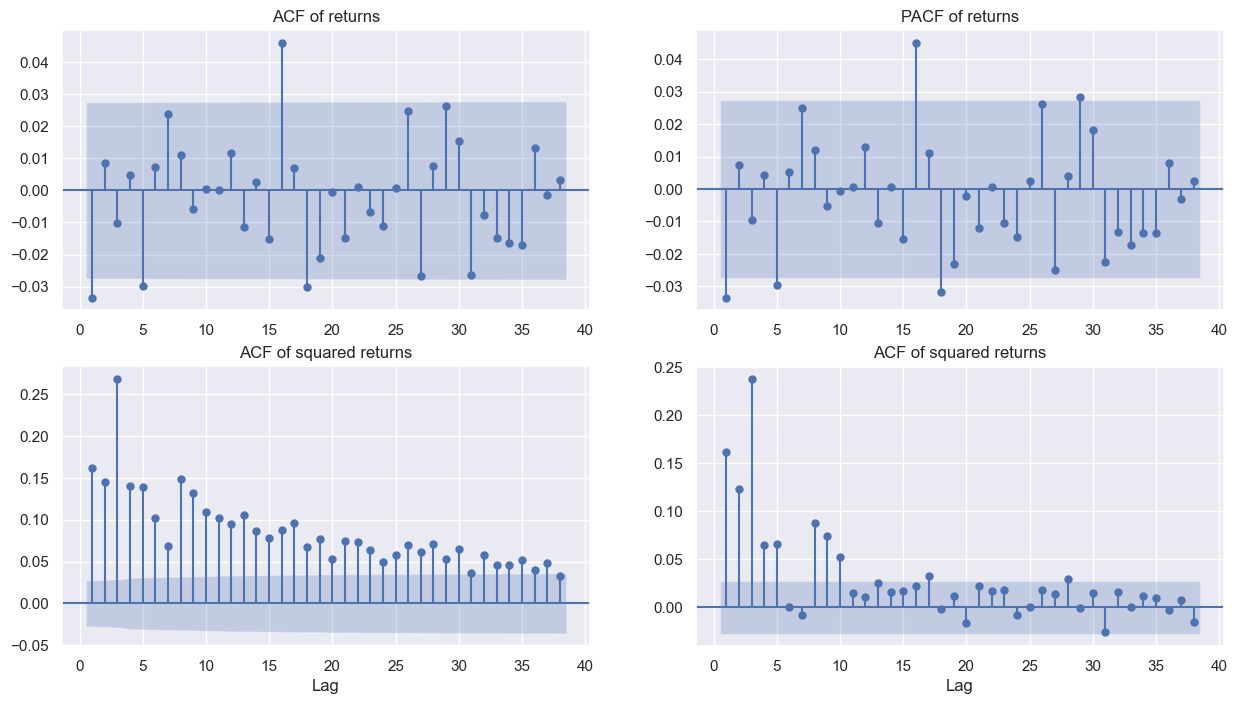

In [195]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    
# RETURNS
plot_acf(returns, ax=axs[0, 0], zero=False) # zero = False to not include lag 0
axs[0, 0].set_title('ACF of returns')

plot_pacf(returns, ax=axs[0, 1], zero=False)
axs[0, 1].set_title('PACF of returns')

# SQUARED RETURNS
plot_acf(returns**2, ax = axs[1, 0], zero=False) 
axs[1, 0].set_title('ACF of squared returns')
axs[1, 0].set_xlabel('Lag')

plot_pacf(returns**2, ax = axs[1, 1], zero=False) 
axs[1, 1].set_title('ACF of squared returns')
axs[1, 1].set_xlabel('Lag')

axs[0, 0].autoscale()
axs[0, 1].autoscale()
axs[1, 0].autoscale()
axs[1, 1].autoscale()

Comments:
- PACF and ACF on the returns do not give us much clues in choosing an appropriate order for p and q for the ARMA model. As we said before, squared returns are more indicative and provide more visual information with respect to the dependence of the observations. 
- slow decay for ACF of the squared residuals and fast decay in the PACF. This suggest a MA structure. 
- ACF of squared returns have a very small decay in the first 10 lags, and then a slightly more pronounced after lag 10
- PACF have a big cutoff value at lag 3 (also in the ACF). This would suggest and order 3 for the AR part of the ARMA mean model. Same conclusion can be drawed for the q order of the MA part, lag 3 seems as the more pronounced. 

However, `ARCH` package do not currently have support for ARMA mean processes, so we'll use just the AR process. 

Let's try with AR(3).

In [196]:
from statsmodels.tsa.arima.model import ARIMA

AR3 = ARIMA(returns, order=(3,0,0)).fit()
print(AR3.summary())


/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5080
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -9253.095
Date:                Thu, 28 Dec 2023   AIC                          18516.190
Time:                        12:15:19   BIC                          18548.855
Sample:                             0   HQIC                         18527.629
                               - 5080                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.022      0.091      0.928      -0.041       0.045
ar.L1         -0.0331      0.008     -3.898      0.000      -0.050      -0.016
ar.L2          0.0071      0.009      0.820      0.4

As we can see from the summary above, the pvalue for the coefficient for lag2 is not significant. So even if by PACF suggested an AR of order 3 we'll chose an AR mean model of order 1. 

In [197]:
AR1 = ARIMA(returns, order=(1,0,0)).fit()
print(AR1.summary())

# Comments: Very small variation in terms of information criterias (AIC, BIC) with respect to the AR of order 3.

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 5080
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -9253.474
Date:                Thu, 28 Dec 2023   AIC                          18512.947
Time:                        12:15:19   BIC                          18532.547
Sample:                             0   HQIC                         18519.811
                               - 5080                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.021      0.093      0.926      -0.040       0.044
ar.L1         -0.0334      0.008     -3.947      0.000      -0.050      -0.017
sigma2         2.2372      0.019    120.722      0.0

/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Comments: Small improvement in terms of information criterias (AIC, BIC) with respect to the AR of order 3.

## GARCH(1, 1) Model

As we explained before, a simple GARCH(1,1) notably provide accurate fit to most of financial data. 

Following the previous explanation, we'll implement the GARCH with a mean process component described by an AR(1).

In [198]:
from arch.univariate import GARCH
from arch import arch_model

# Instantiate the GARCH(1,1) with AR(1) as a mean model. 
garch = arch_model(returns, 
                   mean = 'AR',  # mean process
                   lags=1, # order of the mean process
                   vol = 'GARCH',  # variance process
                   dist = 'normal' # underlying (by hypotheses) distribution of the standardized residuals
                   )


garch_result = garch.fit(update_freq=0, last_obs="2023-06-01")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8152.821842133795
            Iterations: 12
            Function evaluations: 90
            Gradient evaluations: 12


In [199]:
print(garch_result.summary())

# Comments: 
# - information criterias are clearly improved with respect to just the AR(1) model 
# - all coefficients of the vol process are highly significant

                           AR - GARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                      -0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -8152.82
Distribution:                  Normal   AIC:                           16315.6
Method:            Maximum Likelihood   BIC:                           16348.2
                                        No. Observations:                 4940
Date:                Thu, Dec 28 2023   Df Residuals:                     4938
Time:                        12:15:20   Df Model:                            2
                                   Mean Model                                   
                   coef    std err          t      P>|t|        95.0% Conf. Int.
--------------------------------------------------------------------------------
Const            0.0490  1.580e-02      3.104 

/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

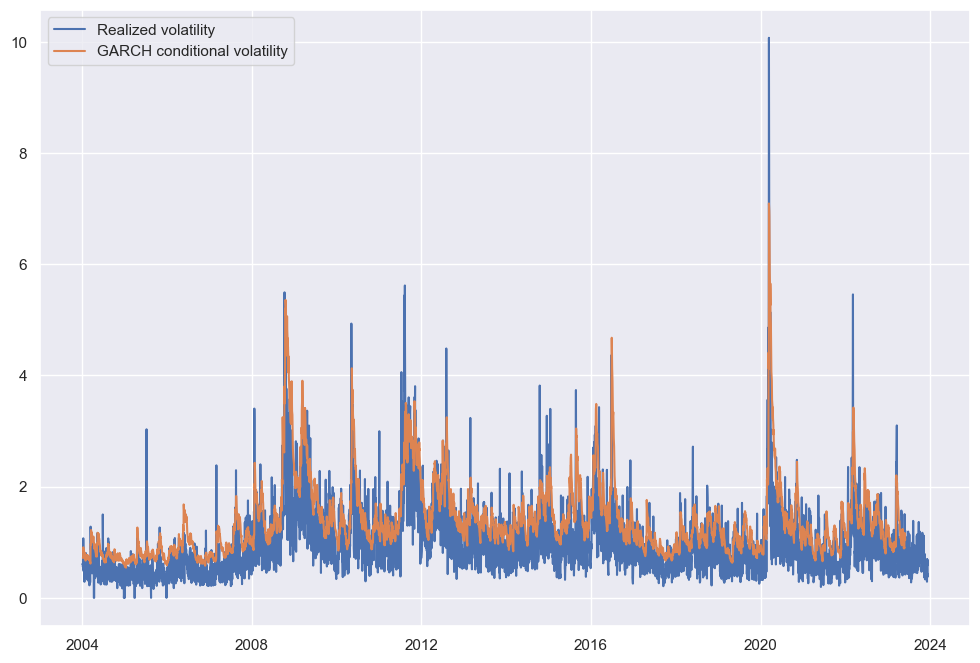

In [200]:
plt.figure(figsize=(12, 8))

plt.plot(realized_vol, label='Realized volatility')

plt.plot(garch_result.conditional_volatility, label='GARCH conditional volatility')
plt.legend()

#### Model validation

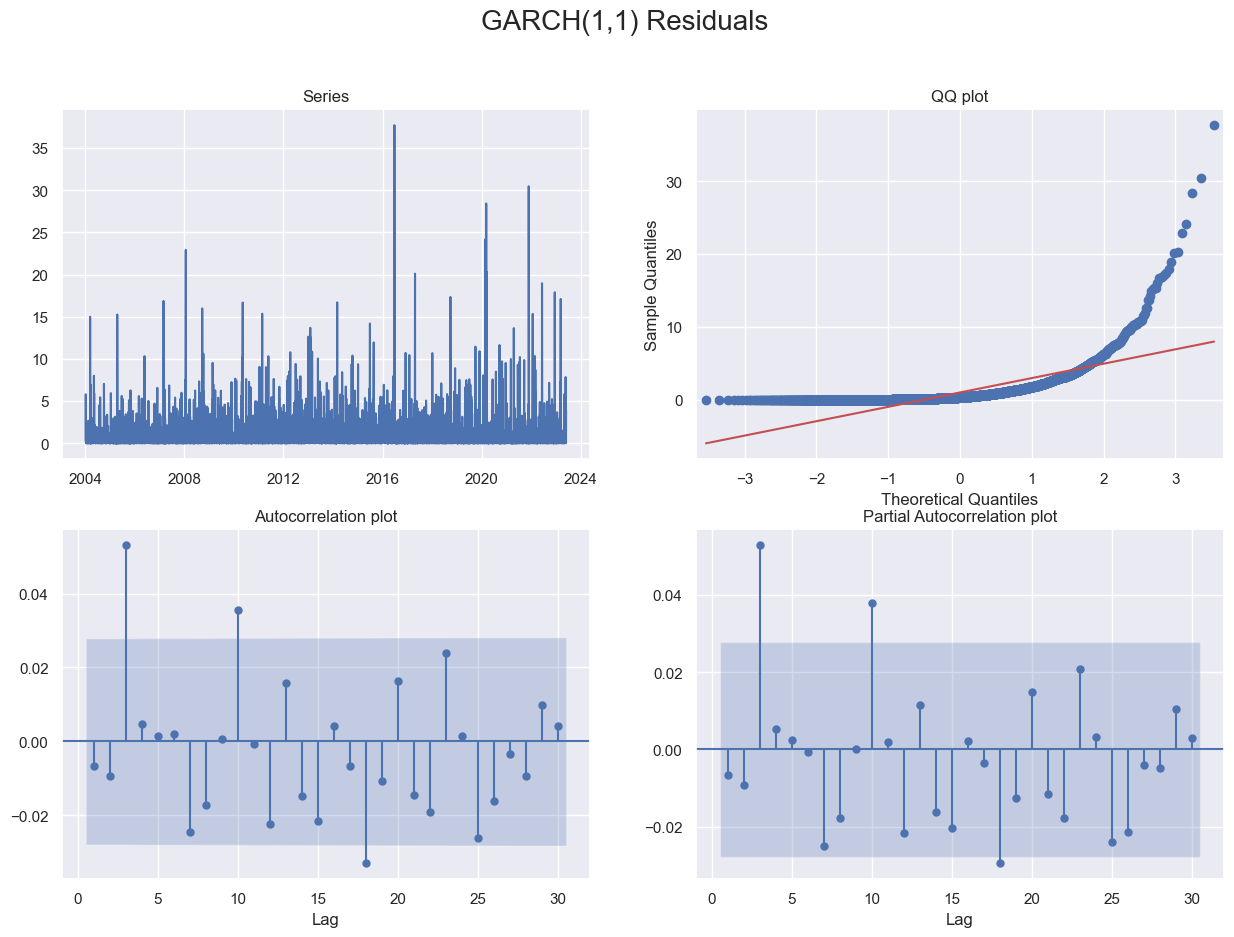

In [201]:
ts_plot(garch_result.std_resid.dropna()**2, max_lags=30, title='GARCH(1,1) Residuals')

COMMENTS:

Fat tails in the QQ plot are still persistent. The QQplot for standardized residual is a very U shaped and this suggest a strong asymmetry that should be modeled by specifying a different distribution for the standardized residuals (this distribution is one of the underlying assumption of the model that assume the std residuals to be iid) or implementing other GARCH models

However, the model has succesfully removed serial correlation (in the squared residuals) as we can observe from the ACF and PACF plots. Even if for few spikes, now residuals look fairly white noise. But is necessary to check also Ljung Box statistics. 

In [202]:
# Ljung box for standardized residuals

sm.stats.acorr_ljungbox(garch_result.std_resid.dropna(), lags=None)

,lb_stat,lb_pvalue
1,0.983069,0.321442
2,1.722799,0.422570
3,1.794924,0.616040
4,2.509789,0.642884
5,2.602054,0.761053
6,4.086333,0.664994
7,4.566886,0.712649
8,5.296256,0.725493
9,5.302098,0.807219
10,5.648435,0.843885


In [203]:
# Ljung box for squared of standardized residuals
sm.stats.acorr_ljungbox(garch_result.std_resid.dropna()**2, lags=None)

,lb_stat,lb_pvalue
1,0.221859,0.637627
2,0.648240,0.723164
3,14.590272,0.002202
4,14.694700,0.005378
5,14.706379,0.011693
6,14.726006,0.022498
7,17.686717,0.013466
8,19.149670,0.014079
9,19.152627,0.023926
10,25.443140,0.004566


The ljung box test exclude now autocorrelation from the standardized residuals, however, when looking at the test statistic for the squared of the standardized residuals, there is still persistence of some kind of correlation after lag 2, since all the remaining lags reject the null hypotheses of absence of autocorrelation. 

This means that there are some remaining patterns or structures in the volatility that are not adequately captured by the model. 

#### Specify a different underlying distribution

One solution to the problem we just faced for the residuals (as also noted by the U shaped QQ plot) is to implement a different kind of distribution, that could be for example the t of student. This kind of distribution shoul give a more leptokurtic behaviour to the residuals, that is a very common characteristic of return (as seen in the introduction to the anomalies of returns).

In [204]:
garch_T_result = arch_model(returns, 
                   mean = 'AR',  # mean process
                   lags=1, # order of the mean process
                   vol = 'GARCH',  # variance process
                   dist = 't' # underlying (by hypotheses) distribution of the standardized residuals
                   ).fit(update_freq=0, last_obs="2023-06-01")

print(garch_T_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8024.602996874088
            Iterations: 16
            Function evaluations: 132
            Gradient evaluations: 16
                              AR - GARCH Model Results                              
Dep. Variable:                    Adj Close   R-squared:                      -0.002
Mean Model:                              AR   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:               -8024.60
Distribution:      Standardized Student's t   AIC:                           16061.2
Method:                  Maximum Likelihood   BIC:                           16100.2
                                              No. Observations:                 4940
Date:                      Thu, Dec 28 2023   Df Residuals:                     4938
Time:                              12:15:22   Df Model:                            2
                         

/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

We can also implement a skewed t distribution and then compare the two new models with the one with gaussian residuals. 

In [205]:
garch_skwT_result = arch_model(returns, 
                   mean = 'AR',  # mean process
                   lags=1, # order of the mean process
                   vol = 'GARCH',  # variance process
                   dist = 'skewt' # underlying (by hypotheses) distribution of the standardized residuals
                   ).fit(update_freq=0, last_obs="2023-06-01")

print(garch_skwT_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7992.174966109986
            Iterations: 18
            Function evaluations: 166
            Gradient evaluations: 18
                                 AR - GARCH Model Results                                
Dep. Variable:                         Adj Close   R-squared:                      -0.001
Mean Model:                                   AR   Adj. R-squared:                 -0.001
Vol Model:                                 GARCH   Log-Likelihood:               -7992.17
Distribution:      Standardized Skew Student's t   AIC:                           15998.3
Method:                       Maximum Likelihood   BIC:                           16043.9
                                                   No. Observations:                 4940
Date:                           Thu, Dec 28 2023   Df Residuals:                     4938
Time:                                   12:15:22   Df Model:          

/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

In [206]:
pd.concat([evaluate(garch_result, name='GARCH(1,1)', realized_vol=realized_vol), 
           evaluate(garch_T_result, name='GARCH(1,1)_T', realized_vol=realized_vol),
           evaluate(garch_skwT_result, name='GARCH(1,1)_skwT', realized_vol=realized_vol)
            ])

,MAE,MSE,AIC,BIC
"GARCH(1,1)",0.504438,0.427830,16315.643684,16348.169287
"GARCH(1,1)_T",0.514381,0.448258,16061.205994,16100.236717
"GARCH(1,1)_skwT",0.504233,0.434174,15998.349932,16043.885776


Comments:

MSE and MAE are slightly higher for the GARCH with t and skewt student, however Information Criteria statistics improved. This suggest us to use one of the models with t distribution. We'll pick the skewed t since it has lower information criterias. 

Let's look now at the Ljung Box.

In [207]:
sm.stats.acorr_ljungbox(garch_skwT_result.std_resid.dropna()**2, lags=None)

,lb_stat,lb_pvalue
1,0.056525,0.812074
2,0.063893,0.968559
3,18.034488,0.000433
4,18.494876,0.000987
5,18.542625,0.002338
6,18.667992,0.004763
7,20.874459,0.003960
8,22.052052,0.004820
9,22.076741,0.008639
10,28.691790,0.001397


As we can see the LB test statistic didn't improve for larger lags, but significantly improved for the first two lags, so it's far less probable to reject the null and confirm autocorrelation in the squared residuals and hence heteroschedasticity in the residuals. 

How can it be the case? The order lags specification for the Ljung Box could be wrong, or maybe the mean process specification or the garch specification are wrong. 

However, before trying to correct the mean or volatility process specification we have one more test. In order to understand what is the case, we can rely on a test that check the presence of heteroschedasticity in the residuals. The null hypotheses is of NO HETEROSCHEDASTICITY. 


In [208]:
from statsmodels.tsa.stattools import breakvar_heteroskedasticity_test

breakvar_heteroskedasticity_test(garch_skwT_result.std_resid.dropna())[1]

0.10156858165382962

As we can see, the null isn't rejected and we can hence confirm that the residuals do no present any heteroschedastic behaviour. In this way we can skip the conclusion of the Ljung Box that was also giving contradictory results. 


## Modeling of asymmetric responses of volatility

It was evident from the last model that even by implementing a t student distribution there is still much to explain in the volatility. 


#### Leverage effect

Leverage effect is one characertistics of the volatility that seems to react differently to a big price increase or a big price drop.

In particular, volatility tends to increase more during periods of negative returns than during periods of positive returns, as if there is was a positive correlation between past negative returns and future volatility.

This phenomenon is one of the key characteritics of volatility clustering. Since GARCH models assume that positive and negative news have a symmetric impact on the volatility of the returns, we can improve our model by implementing techniques to capture this kind of asymmetry. The asymmetry regards the response of volalitiliy to good news and bad news. Bad news in reality have a stronger effect on volatility, resonating and increasing volatility for longer periods and with a greater impact compared to good news. 

There are two extensions of the GARCH model that allows to better capture the asymmetric behaviour of the volatility: EGARCH and GJR-GARCH. 


## EGARCH

The exponential generalized autoregressive conditional heteroskedastic (EGARCH) model was developed by Nelson & Cao in 1991. In particular, to allow for asymmetric effects between positive and negative asset returns, the model considers a weighted innovation:

$$g(\epsilon_t) = \theta\epsilon_t + \gamma[|\epsilon_t| - E(|\epsilon_t|)] \ \ \ \ (1)$$

where both $\epsilon_t$ and $(|\epsilon_t| - E(|\epsilon_t|))$ are zero iid sequences. 
These formulation of $g(\epsilon_t)$ allows the sign and magnitude of $\epsilon_t$ to have a separate effect on the volatility.

Formally, an EGARCH(p,q) is defined as:

$$ \log{\sigma^2}_t = \omega + \sum^q_{k=1}{\beta_kg(\epsilon_{t-k})} + \sum^p_{k=1}{\alpha_k}\log{\sigma^2}_{t-k} \ \ \ \ (2)$$

Since $\log{\sigma^2}_t$ could be negative, no restrictions are applied to the parameters. 



In [209]:
Egarch_skwT_result = arch_model(returns, 
                   mean = 'AR',  # mean process
                   lags=1, # order of the mean process
                   vol = 'EGARCH',  # variance process
                   o = 1,
                   dist = 'skewt' # underlying (by hypotheses) distribution of the standardized residuals
                   ).fit(update_freq=0, last_obs="2023-06-01")

print(Egarch_skwT_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7888.857032997312
            Iterations: 15
            Function evaluations: 164
            Gradient evaluations: 15
                                AR - EGARCH Model Results                                
Dep. Variable:                         Adj Close   R-squared:                       0.001
Mean Model:                                   AR   Adj. R-squared:                  0.001
Vol Model:                                EGARCH   Log-Likelihood:               -7888.86
Distribution:      Standardized Skew Student's t   AIC:                           15793.7
Method:                       Maximum Likelihood   BIC:                           15845.8
                                                   No. Observations:                 4940
Date:                           Thu, Dec 28 2023   Df Residuals:                     4938
Time:                                   12:15:23   Df Model:          

/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

In [210]:
sm.stats.acorr_ljungbox(Egarch_skwT_result.std_resid.dropna()**2, lags=None)

,lb_stat,lb_pvalue
1,0.265368,0.606456
2,1.027960,0.598110
3,7.893996,0.048254
4,7.898595,0.095364
5,8.550456,0.128395
6,8.551558,0.200413
7,10.004101,0.188341
8,10.454091,0.234589
9,10.460683,0.314492
10,14.760539,0.141039


Standardized residuals are finally behaving like white noise. We can clearly see that from the Ljung Box test now also higher order lags of the test don't reject the null hypotheses. This hence mean that a model capable of dealing with the volatility asymmetry is better suited for this type of market data and we should continue and focus on this models. 

Now we can also look and compare EGARCH statistics with the other models:

In [211]:
pd.concat([evaluate(garch_result, name='GARCH(1,1)', realized_vol=realized_vol), 
           evaluate(garch_T_result, name='GARCH(1,1)_T', realized_vol=realized_vol),
           evaluate(garch_skwT_result, name='GARCH(1,1)_skwT', realized_vol=realized_vol),
           evaluate(Egarch_skwT_result, name='EGARCH(1,1)_skwT', realized_vol=realized_vol)
            ])

,MAE,MSE,AIC,BIC
"GARCH(1,1)",0.504438,0.427830,16315.643684,16348.169287
"GARCH(1,1)_T",0.514381,0.448258,16061.205994,16100.236717
"GARCH(1,1)_skwT",0.504233,0.434174,15998.349932,16043.885776
"EGARCH(1,1)_skwT",0.478252,0.372181,15793.714066,15845.755031


Comments: EGARCH improved a lot the error measures, especially the MAE. Also, information criterias improved, even if by a little. 

## GJR-GARCH

For a GJR-GARCH(1,1):

$$\sigma^2_t =  \omega + \alpha_1\epsilon^2_{t-1} + \gamma_1\epsilon^2_{t-1}I_{t-1} + \beta_1\sigma^2_{t-1} $$

where $I_{t-1}$ is an indicator function that:

$$ I_{t-1} = \begin{cases} 1 &\text{if } \epsilon_{t-1} < 0 \\ 0 &\text{if } \epsilon_{t-1} \ge 0 \end{cases} $$

By implementing the indicator function in the volatility process the model gives one extra parameters $\gamma_1$ that emphasises the effect of negative past news on the conditional volatility and allows the model to better retrace the asymmetry in the volatility.

In [212]:
GJRgarch_skwT_result = arch_model(returns, 
                   mean = 'AR',  # mean process
                   lags=1, # order of the mean process
                   vol = 'GARCH',  # variance process
                   o = 1, # order of the asymmetric innovation, =1 means GJR GARCH
                   dist = 'skewt' # underlying (by hypotheses) distribution of the standardized residuals
                   ).fit(update_freq=0, last_obs="2023-06-01")

print(GJRgarch_skwT_result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7920.354372073743
            Iterations: 20
            Function evaluations: 207
            Gradient evaluations: 20
                               AR - GJR-GARCH Model Results                              
Dep. Variable:                         Adj Close   R-squared:                       0.001
Mean Model:                                   AR   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -7920.35
Distribution:      Standardized Skew Student's t   AIC:                           15856.7
Method:                       Maximum Likelihood   BIC:                           15908.7
                                                   No. Observations:                 4940
Date:                           Thu, Dec 28 2023   Df Residuals:                     4938
Time:                                   12:15:23   Df Model:          

/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/tommasograndi/anaconda3/envs/TSproj/lib/python3.11/site-packages/arch/univariate/base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated 

In [213]:
sm.stats.acorr_ljungbox(GJRgarch_skwT_result.std_resid.dropna()**2, lags=None)

,lb_stat,lb_pvalue
1,0.813081,0.367211
2,2.728284,0.255600
3,5.916514,0.115743
4,5.944837,0.203306
5,6.332510,0.275195
6,6.337442,0.386470
7,8.048719,0.328318
8,9.000369,0.342265
9,9.046080,0.433032
10,13.416276,0.201319


GJR shows again good signs, as with EGARCH, higher order lags of the Ljung Box statistics improved compared to non-asymmetric GARCH models. 

In [214]:
pd.concat([evaluate(garch_result, name='GARCH(1,1)', realized_vol=realized_vol), 
           evaluate(garch_T_result, name='GARCH(1,1)_T', realized_vol=realized_vol),
           evaluate(garch_skwT_result, name='GARCH(1,1)_skwT', realized_vol=realized_vol),
           evaluate(Egarch_skwT_result, name='EGARCH(1,1)_skwT', realized_vol=realized_vol),
           evaluate(GJRgarch_skwT_result, name='GJR-GARCH(1,1)_skwT', realized_vol=realized_vol)
            ])

,MAE,MSE,AIC,BIC
"GARCH(1,1)",0.504438,0.427830,16315.643684,16348.169287
"GARCH(1,1)_T",0.514381,0.448258,16061.205994,16100.236717
"GARCH(1,1)_skwT",0.504233,0.434174,15998.349932,16043.885776
"EGARCH(1,1)_skwT",0.478252,0.372181,15793.714066,15845.755031
"GJR-GARCH(1,1)_skwT",0.501092,0.458319,15856.708744,15908.749709


As we can see, GJR-GARCH stepped back from the results of the EGARCH both in termes of error measures but also in terms of information criterias.

For this reason, EGARCH is currently the best model. 

#### News Impact Curve

As we see, asymmetric models are better able to capture volatility irregular behaviour in the market. But why?

News Impact Curves are a way to observe the aymmetric response of volatility with respect to the market news. Given an estimated model, it depicts the next-period volatility that would result from various positive and negative shocks.

Before discussing the utility of news impact curves, we should define a function that is able to plot one relative to the basic GARCH model, and one for the GJR-GARCH model (for simplicity, we'll omit the one for the EGARCH). 

The equations for a NIC, that plot residual at time t-1 versus the conditional variance at time t, were defined in the paper "Measuring and Testing the Impact of News on Volatility " written by Engle in 1993.

As we know, the residuals in the context of an ARCH model are calculated as $\epsilon_t = r_t - m_t$ . Engle defines these in the paper as *"unexpected returns"* and treat them as a *"collective measure of news at time t"*. 

Following this definition he explains that a *"positive $\epsilon_t$ (an unexpected increase in price) suggests the arrival of good news, while a negative $\epsilon_t$ (an unexpected decrease in price) suggests the arrival of bad news. Further, a large value of $|\epsilon_t|$ implies that the news is "significant" or "big" in the sense that it produces a large unexpected change in price."*
These paper hence try to create a visual way to inspect the the capability of GARCH models to capture the asymmetry of positive and negative news with respect to the object of the forecast, the volatility.


**GARCH NIC**  <br>
The equation for the GARCH(1,1) News Impact Curve is:

$$\sigma_t = A + \alpha\epsilon^2_{t-1} $$

where, 
- $\sigma_t$ is the conditional variance at time t
- $\epsilon_{t-1}$ is the residual at time t-1
- $A = \omega + \beta\sigma^2$
- $\sigma$ is the unconditional return variance, calculated as $\frac{\omega}{1 + \alpha}$
- $\omega , \alpha, \beta $ are the parameters estimated in the GARCH(1,1) model


**GJR-GARCH NIC** <br>
The two equations for the GJR-GARCH(1,1,1) News Impact Curve are: 

$$\sigma_t = A + \alpha\epsilon_{t-1}^2, \ \ \text{for} \  \epsilon_{t-1}>0 $$ 
$$\sigma_t = A + (\alpha + \gamma)\epsilon_{t-1}^2, \ \ \text{for} \ \epsilon_{t-1}<0 $$ 

where, 
- $\sigma_t$ is the conditional variance at time t
- $\epsilon_{t-1}$ is the residual at time t-1
- $A = \omega + \beta\sigma^2$
- $\sigma^2$ is the unconditional variance, equal to $\frac{\omega}{(1-\alpha - \frac{\gamma}{2}- \beta)}$
- $\omega , \alpha, \beta, \gamma $ are the parameters estimated in the GJRGARCH(1,1,1) model


For this two models, the residuals at time t-1 are plotted against the conditional variance at time t, calculated according to the above equations.

In [215]:
def NIC(model, name : str):

    vols = model.conditional_volatility.dropna() # extract sigma_t from the model
    epsi = model.resid.shift(1).dropna() #extract residuals and shift by 1 to get epsilon_t-1

    # merge the two series so that they have the same dates (and same observations)
    merge = pd.merge(vols, epsi, left_index=True, right_index=True, how='inner')

    # create a new column for the squared residuals
    merge['epsi_squared'] = merge.iloc[:,1]**2
    
    ## GARCH(1,1)
    if name == 'GARCH': 
        omega = model.params[2] #constant term
        alpha = model.params[3]
        beta = model.params[4]
        unco_var = omega / (1 + alpha) #unconditional variance

        A = omega + beta * unco_var

        # Create the column for the conditional variance of the News Impact Curve
        merge['ht'] = A + (alpha * merge['epsi_squared'])


    ## GJR-GARCH(1,1)
    elif name == 'GJR':

        omega = model.params[2] #constant term
        alpha = model.params[3]
        beta = model.params[5]
        gamma = model.params[4]
        unco_var = omega / (1 - alpha - (gamma/2) - beta) #unconditional variance

        A = omega + beta * unco_var

        # Define the function that will calculate A according to the two formulas conditions
        def gjr(value):
            if value > 0:
                return (A + alpha * (value**2))
            elif value < 0:
                return (A + (alpha + gamma) * (value**2))

        # Apply the function to create the ht column
        # Create the column for the conditional variance of the News Impact Curve
        merge['ht'] = merge.iloc[:,1].apply(gjr)    

    merge.sort_values(by='resid', inplace=True)
    plt.plot(merge.iloc[:,1].values, merge['ht'].values)
    plt.xlabel('$\epsilon_{t-1}$')
    plt.ylabel('$\sigma^2_t$')
    plt.title(f'News Impact Curve for {name}')


Let's visualize the two NIC curves. What these two curves tell us?

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_2962/3436681676.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  omega = model.params[2] #constant term
/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_2962/3436681676.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[3]
/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_2962/3436681676.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

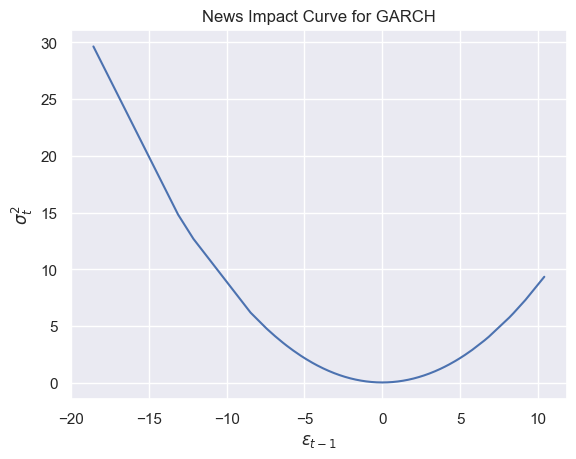

In [216]:
NIC(garch_skwT_result, name='GARCH')

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_2962/3436681676.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  omega = model.params[2] #constant term
/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_2962/3436681676.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = model.params[3]
/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_2962/3436681676.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.il

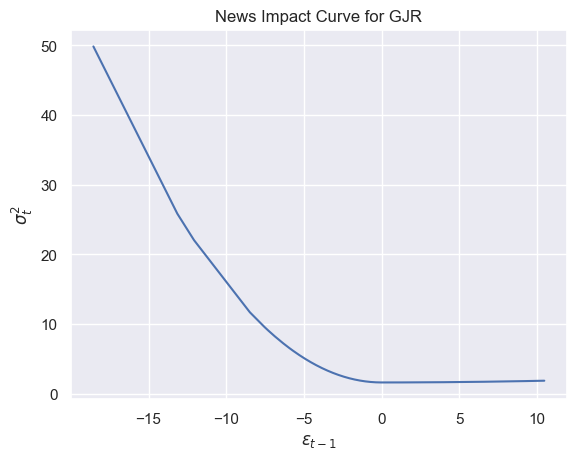

In [217]:
NIC(GJRgarch_skwT_result, name='GJR')

As we can see, the two curves appear to be clearly different. The GJR-GARCH curve, that was developed to better capture the asymmetric information of the residuals onto the conditional variance in the context of the Leverage Effect, has a steeper curve for the negatives values of the past residuals (the news) and an almost horizontal curve (that appear extremely horizontal due to the scale of the plot) for the positive values of the residuals. What does this implies? That the GJR GARCH was actually able to measure and replicate the volatility asymmetry that can be traced back just by observing the volatility clusters. Instead, the basic GARCH, is not able to do so since its NIC curve is almost perfectly symmetrical and hence the model regards equally a positive or negative past residuals for determining the conditional volatility.

## TGARCH

Another model that try to deal with asymmetry in the volatilit is TGARCH.

The Threshold GARCH was developed by Zakoian in 1994 and is similar to GJR GARCH. The main difference is that specification is on conditional standard deviation instead on the conditional variance.

For a TGARCH(1,1), the variance process become:

$$\sigma_t =  \omega + \alpha_1^+\epsilon^+_{t-1} - \alpha_1^-\epsilon^-_{t-1} + \beta_1^+\sigma^+_{t-1} - \beta_1^-\sigma^-_{t-1}$$

where :

$ \ \ \ \ \ \ \ \epsilon^+_{t-1} = \begin{cases} \epsilon_{t-1} &\text{if } \epsilon_{t-1}>0 \\ 0 &\text{if } \epsilon_{t-1}\le 0 \end{cases} \ \ \ \ \ \ \ $ and likewise $ \ \ \ \ \ \ \epsilon^-_{t-1} = \begin{cases} \epsilon_{t-1} &\text{if } \epsilon_{t-1}\le0 \\ 0 &\text{if } \epsilon_{t-1} > 0 \end{cases} $


This allows to have different estimated parameters for positive ($\alpha^+_1, \beta^+_1$) and negative ($\alpha^-_1, \beta^-_1$) news shocks and past conditional volatilities that evidently will have a diversified effect on the actual conditional volatility, helping to capture the asymmetry in the market. 

TGarch is discussed in the R markdown notebook since ARCH package in Python do not currently support it. 


Previous data (returns and realized vol) is exported as a csv file in order to use it in Rstudio.

In [218]:
import os 

os.getcwd()

'/Users/tommasograndi/Documents/GitHub/market-vol-forecasting-with-GARCH-models'

In [219]:
path_ = '/Users/tommasograndi/Documents/GitHub/market-vol-forecasting-with-GARCH-models/TGARCH R/returns.csv'

In [220]:
# export log returns
returns.to_csv(path_or_buf=path_, date_format='%d/%m/%Y')

In [221]:
path_ = '/Users/tommasograndi/Documents/GitHub/market-vol-forecasting-with-GARCH-models/TGARCH R/realized.csv'

# export realized vol
realized_vol.to_csv(path_or_buf = '/Users/tommasograndi/Documents/GitHub/market-vol-forecasting-with-GARCH-models/TGARCH R/realized.csv', date_format='%d/%m/%Y')

## Forecast Model Evaluation

Following the conclusion drawn in the R notebook `TGARCH_R.rmd` , EGARCH is chose as the best model, both in terms of Error Measures and Information Criterias. 

The last thing to test is its capability of forecasting in out of sample data. We recall that all the models were fitted until '2023-05-31' so we have aproximately a 6 months forecast horizon that last until the '2023-12-13'. 

We'll perform a 1 step ahead forecast, so each day after the 31st of May will be forecasted based on the previous observation residuals, and forecasted conditional variances, as well as on the parameters of the EGARCH model fitted with data from 2004 to 31st may of 2023. 


In [222]:
## Now let's forecast the volatility with our model (we fitted data until 2023-01-01)
# Default is one step ahead forecast 
forecasts_1 = Egarch_skwT_result.forecast(reindex=False)

for_vol_1 = np.sqrt(forecasts_1.variance) #extract forecasted volatility for 1 step ahead
for_vol_1

for_vol_1.head()
# column h.1 represent the forecast of each day (each row) for the following day
# row 2023-05-31 is the forecast the 31st of May for the 1st of June

,h.1
Date,
2023-05-31,1.394761
2023-06-01,1.329072
2023-06-02,1.267626
2023-06-05,1.293324
2023-06-06,1.233026


The first row 2023-05-31 is the forecast the 31st of May for the 1st of June.

Thus, in order to have the forecast value in the concerned day of the forecast, we'll shift the dataframe by 1 day. 

In [223]:
for_vol_1 = for_vol_1.shift(1).dropna()
for_vol_1.head()

,h.1
Date,
2023-06-01,1.394761
2023-06-02,1.329072
2023-06-05,1.267626
2023-06-06,1.293324
2023-06-07,1.233026


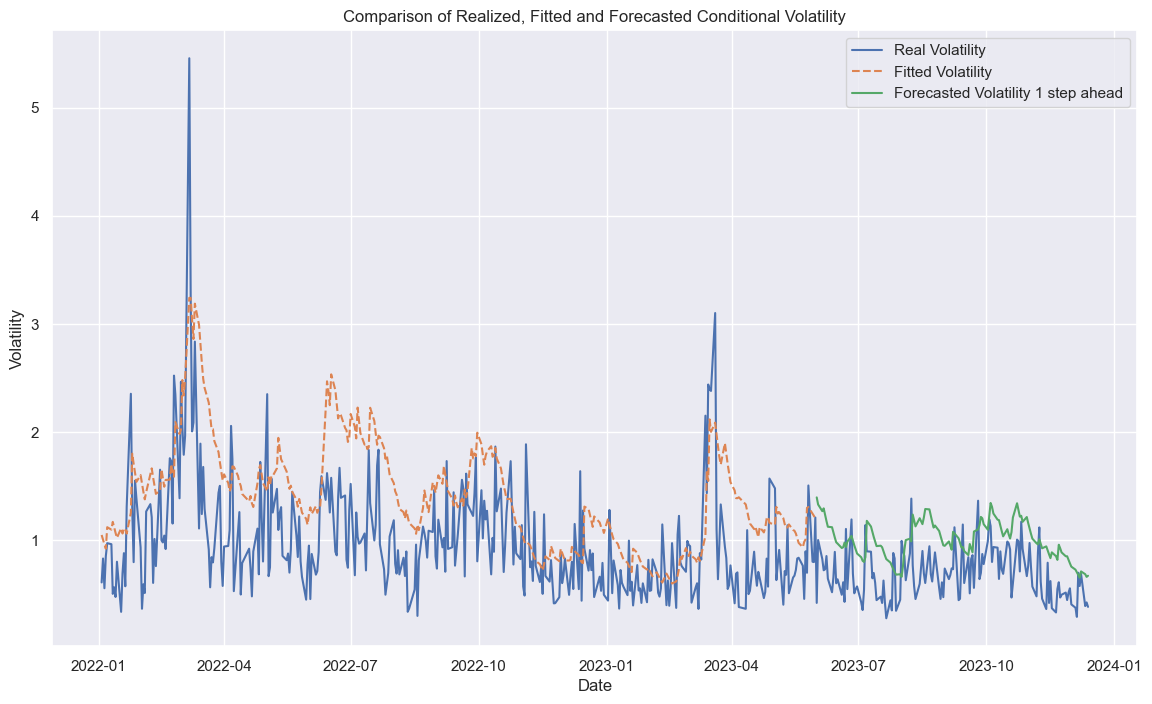

In [225]:
# Plot realized volatility vs fitted volatility vs forecasted volatility (focus from 2022 on)

fitted = Egarch_skwT_result.conditional_volatility.dropna() # store the conditional vola of the EGARCH model

plt.figure(figsize=(14, 8))
plt.plot(realized_vol['2022-01-01': ], label='Real Volatility', linewidth=1.5) #realized VOL
plt.plot(fitted['2022-01-01': ], label='Fitted Volatility', linestyle='dashed', linewidth=1.5) # FITTED
plt.plot(for_vol_1, label='Forecasted Volatility 1 step ahead') # 1 step ahead forecaste vol


plt.title('Comparison of Realized, Fitted and Forecasted Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

As we can see the model isn't catching all the variations in volatility that the GK provide, but is really fitting well the trend in the data. 

In [235]:
realized2 = pd.Series(returns.rolling(window = 5).std(), index = returns.index)
str(for_vol_1.index[-1])

'2023-12-13 00:00:00'

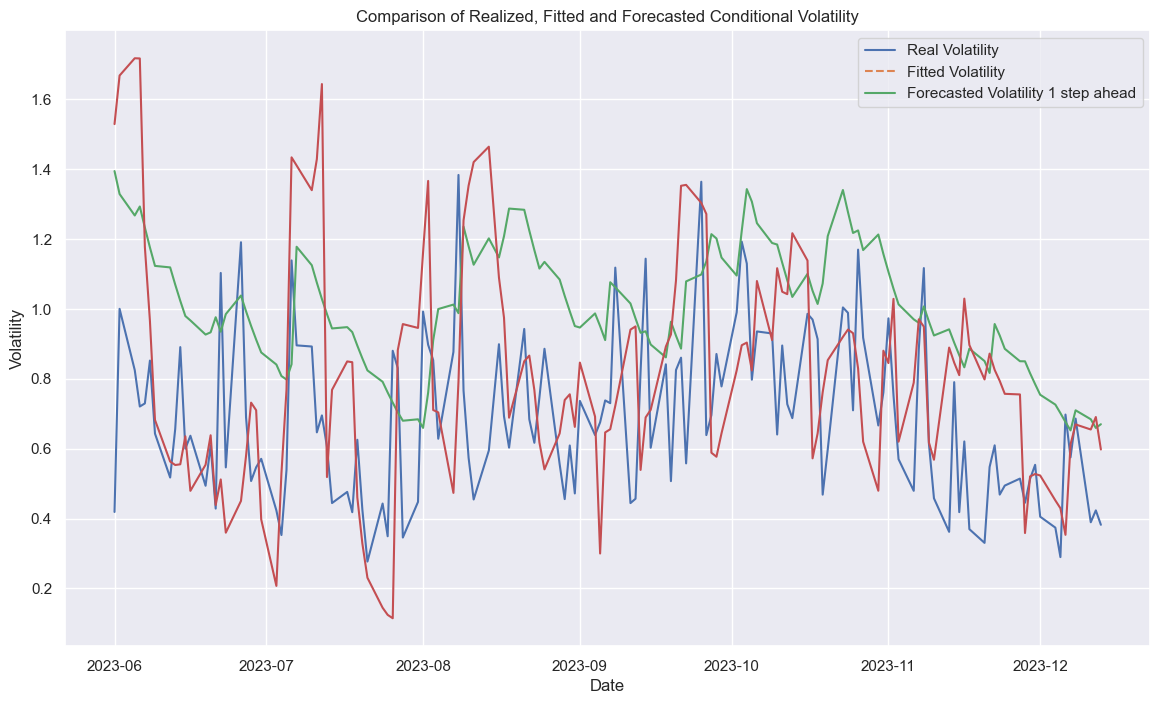

In [237]:
# Plot realized volatility vs fitted volatility vs forecasted volatility (focus from 2022 on)

fitted = Egarch_skwT_result.conditional_volatility.dropna() # store the conditional vola of the EGARCH model

plt.figure(figsize=(14, 8))
plt.plot(realized_vol['2023-06-01': ], label='Real Volatility', linewidth=1.5) #realized VOL
plt.plot(fitted['2023-06-01': ], label='Fitted Volatility', linestyle='dashed', linewidth=1.5) # FITTED
plt.plot(for_vol_1, label='Forecasted Volatility 1 step ahead') # 1 step ahead forecaste vol
plt.plot(realized2['2023-06-01': for_vol_1.index[-1]])


plt.title('Comparison of Realized, Fitted and Forecasted Conditional Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()